In [1]:
from dataloader import PriceScenarioDataset
from utils import VaR, ES, score
from Discriminator import Discriminator
from Generator import Generator
from Tradining_Strategies import TradingStrategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from preprocess.acf import *
# from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from model.torch_tcn import *

In [2]:
num_epochs = 100
# nz = 3
batch_size = 128
#seq_len = 127
# clip= 0.01
lr = 0.01

noise_size=100
pnl_size=100
market_size=5

if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu"

device = torch.device(dev) 

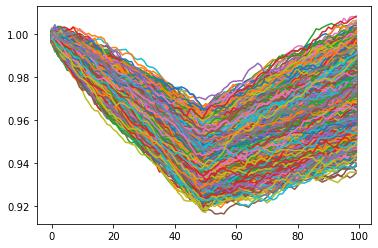

In [3]:
from scipy.stats import norm
def gen_toy_sample(x0,n):
    x0 = np.asarray(x0)
    N = norm.rvs(size=(n), scale=1e-3)
    u = np.concatenate((np.random.uniform(-1.5e-3,-8e-4,int(n/2)),np.random.uniform(4e-4,8e-4,int(n/2))))
    r = N+u
    out = np.empty(r.shape)
    np.cumsum(r, axis=-1, out=out)
    out += np.expand_dims(x0, axis=-1)
    return out
toy_sample_n = 10000
toy_sample = []
for i in range(toy_sample_n):
    toy_sample.append(gen_toy_sample(1,100))
toy_sample = np.array(toy_sample)

toy_sample_price_scenarios = np.empty(toy_sample.shape)
for i in range(toy_sample_n):
    toy_sample_price_scenarios[i,:] = toy_sample[i,:] #np.log(toy_sample[i,:]/toy_sample[i,0])
    plt.plot(list(range(100)),toy_sample_price_scenarios[i,:])

In [4]:
toy_sample_tensor = torch.tensor(toy_sample_price_scenarios).cuda()
dataloader = torch.utils.data.DataLoader(toy_sample_tensor, batch_size=batch_size,drop_last=True,shuffle=True)

In [5]:
data_df = pd.read_csv("./data/Portfolios_Formed_on_ME_daily.csv", error_bad_lines=False)

C:\Users\ytc19\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x)[0]

'0.39'

In [7]:
# lo30_df=data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x).apply(float)
# lo30_df=lo30_df.fillna(lo30_df.mean())
# lo30_data=lo30_df.to_numpy(dtype=np.float32).reshape(1,-1)
# lo30_data = torch.tensor(lo30_data,).cuda()
# dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,drop_last=True,shuffle=True)
# for i in dataloader:
#     print(i[0].shape,i[-1].shape)
#     break
# len(dataset)

In [15]:
torch.ones_like(torch.tensor((2,1)))+0

tensor([1, 1])

In [5]:
import torch.optim as optim
from tqdm import tqdm

generator = Generator(noise_size=noise_size,
                      pnl_size=pnl_size,market_size=batch_size
                     ).to(device)

train = True
# batch*pnl
trade_strategy_1 = TradingStrategy("buy-hold",10,(0,0),(1e-2,1e-2))
trade_strategy_2 = TradingStrategy("MA",10,(0,0),(1e-2,1e-2))
trade_strategy_3 = TradingStrategy("MOM",10,(0,0),(1e-2,1e-2))
if train:
    discriminator = Discriminator(pnl_size=pnl_size).to(device)
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    scheduler_disc = torch.optim.lr_scheduler.CosineAnnealingLR(disc_optimizer, T_max=1000, eta_min=0)
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
    scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(gen_optimizer, T_max=1000, eta_min=0)

#     dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
#     dataset = Loader32(log_returns_preprocessed, 1)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    c=0
    t = tqdm(range(1000))
    generator.train()
    discriminator.train()
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):
#             print(data.shape)
            c+=1
#             print(idx,epoch)
            if True: #(idx<=10 and epoch ==0):
                discriminator.zero_grad()
                ps_real = data#.permute(0,2,1).squeeze(-1)
    #             score_real = data[-1].reshape(batch_size,-1)

                ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach()
                
                disc_loss = 0
                for trade_strategy in [trade_strategy_1,trade_strategy_2,trade_strategy_3]:

                    ts_real = trade_strategy.get_strategy_PnL(ps_real)#,torch.ones_like(ps_real))
                    ts_fake = trade_strategy.get_strategy_PnL(ps_fake)#,torch.ones_like(ps_fake))

                    fake_ve = discriminator(ts_fake)
                    fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]
                    real_ve = discriminator(ts_real)
                    real_v,real_e = real_ve[:,0],real_ve[:,1]
                    if idx % 180 == 0:
                        print("disc:current fake and real ves: ",fake_ve[0],real_ve[0])


                    disc_loss += torch.mean(score(fake_v,fake_e,ps_real,0.05)) - \
                                          torch.mean(score(real_v,real_e,ps_real,0.05))

    #             print('Discriminator Loss: %.8f' % (disc_loss.item()))
                disc_loss/=3
                disc_loss.backward()

                disc_optimizer.step()
                scheduler_disc.step()
            

#             discriminator.zero_grad()
#             real = data.to(device)
#             batch_size, seq_len = real.size(0), real.size(1)
#             noise = torch.randn(batch_size, nz, seq_len, device=device)
#             fake = generator(noise).detach()
#             disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
#             disc_loss.backward()
#             disc_optimizer.step()

#             for dp in discriminator.parameters():
#                 dp.data.clamp_(-clip, clip)
    
            if True: #not (idx<=10 and epoch ==0):# or idx % 2 == 0:
                for i in range(1):
                    generator.zero_grad()
                    discriminator.zero_grad()
                    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1)
                    ts_fake = trade_strategy.get_strategy_PnL(ps_fake)

                    fake_ve = discriminator(ts_fake)
                    fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]

    #                 print(fake_ve[0],"asdsa")

                    gen_loss = -torch.mean(score(fake_v,fake_e,ps_real,0.05))

    #                 gen_loss = -torch.mean(discriminator(generator(noise)))
                    gen_loss.backward()
                    gen_optimizer.step()
                    scheduler_gen.step()
                if idx % 180 == 0:
                    print("gen:current fake ve: ",fake_ve[0])
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f"trained_generator_epoch_{epoch}.pth")

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

disc:current fake and real ves:  tensor([-1.0043, -0.8095], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.1380, -0.0176], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3912,  0.5931], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.0301, -0.0052], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 0.8272, -0.6804], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.0301, -0.0052], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 31.5226, -19.3521], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -259321371.53604108 Generator Loss: -3540.49553366:   0%|         | 1/1000 [00:02<40:33,  2.44s/it]

disc:current fake and real ves:  tensor([ 15476.6299, -14865.1289], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-698.3773,  719.6967], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 10840.7930, -10410.6357], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 313.3450, -301.0588], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-76.2893,  86.5946], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 313.3450, -301.0588], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-64.1389,  72.9356], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -272620785.46885872 Generator Loss: -17263.52893837:   0%|        | 2/1000 [00:04<35:33,  2.14s/it]

disc:current fake and real ves:  tensor([ 15950.1221, -15324.6045], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-708.4638,  727.2424], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 10921.5518, -10491.4922], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 605.4425, -582.5459], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-82.8559,  93.6967], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 605.4425, -582.5459], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-772.1106,  824.0143], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -476775014.88631213 Generator Loss: -64830.17994447:   0%|        | 3/1000 [00:06<31:45,  1.91s/it]

disc:current fake and real ves:  tensor([ 29796.5176, -28629.0215], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-737.5292,  756.4518], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 16528.2227, -15877.2490], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 891.9030, -858.7644], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1016.4688,  1055.8333], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 891.9030, -858.7644], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-242.5457,  269.8809], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -574943036.87231660 Generator Loss: -4156.07789624:   0%|         | 4/1000 [00:07<29:46,  1.79s/it]

disc:current fake and real ves:  tensor([ 31882.0352, -30648.9336], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-587.1032,  622.7430], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 21405.4102, -20575.2383], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1324.3485, -1275.8717], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-199.5301,  223.8651], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1324.3485, -1275.8717], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-170.0834,  191.3567], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -636872782.96291912 Generator Loss: -8104.57444031:   0%|         | 5/1000 [00:09<27:53,  1.68s/it]

disc:current fake and real ves:  tensor([ 35696.1367, -34322.6016], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-609.5413,  642.4974], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 23218.8398, -22323.0625], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1642.6781, -1583.0427], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-329.0064,  364.6805], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1642.6781, -1583.0427], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-94.9875, 107.1000], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -648077067.45289719 Generator Loss: -16164.92180286:   1%|        | 6/1000 [00:10<26:51,  1.62s/it]

disc:current fake and real ves:  tensor([ 20519.3672, -19733.7188], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-646.5984,  676.8234], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 13246.2910, -12737.8701], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1916.2240, -1847.1332], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-121.7271,  136.6327], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1916.2240, -1847.1332], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-622.5277,  684.8160], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -677116515.71443558 Generator Loss: -33495.10703028:   1%|        | 7/1000 [00:12<26:09,  1.58s/it]

disc:current fake and real ves:  tensor([ 26344.4141, -25339.6445], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-667.3525,  695.0811], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 15984.6904, -15373.5410], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2136.9670, -2060.3201], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-302.2202,  333.8823], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2136.9670, -2060.3201], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-959.0851, 1029.6812], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -677362962.62487590 Generator Loss: -63461.88659757:   1%|        | 8/1000 [00:13<25:55,  1.57s/it]

disc:current fake and real ves:  tensor([ 22544.9023, -21687.2637], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-659.9636,  687.6773], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 14338.3242, -13791.5586], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2307.5071, -2224.9473], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-133.3125,  149.2980], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2307.5071, -2224.9473], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-961.4116, 1016.1860], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -745206911.68746734 Generator Loss: -72087.23689741:   1%|        | 9/1000 [00:15<25:50,  1.56s/it]

disc:current fake and real ves:  tensor([ 23124.4258, -22245.2559], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-659.1060,  687.6339], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 14499.1602, -13946.5918], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2431.6506, -2344.6636], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-169.1200,  188.1853], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2431.6506, -2344.6636], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-825.9719,  876.4536], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -760870525.06104624 Generator Loss: -69191.15005161:   1%|       | 10/1000 [00:16<26:12,  1.59s/it]

disc:current fake and real ves:  tensor([ 24113.3691, -23197.8848], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-658.1314,  687.2864], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 14760.2188, -14198.4961], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2511.5366, -2421.8159], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-223.6205,  247.4028], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2511.5366, -2421.8159], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1134.2129,  1191.6993], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -711411227.23511744 Generator Loss: -67288.68067919:   1%|       | 11/1000 [00:18<26:02,  1.58s/it]

disc:current fake and real ves:  tensor([ 47832.2617, -46019.4531], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-645.0750,  674.5432], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 25542.5840, -24571.8906], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2553.1089, -2462.0620], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1287.6207,  1350.9148], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2553.1089, -2462.0620], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-256.5737,  283.4540], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -786699198.12270522 Generator Loss: -87570.73365165:   1%|       | 12/1000 [00:19<25:57,  1.58s/it]

disc:current fake and real ves:  tensor([ 24753.1699, -23814.2344], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-640.2295,  669.8820], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 14824.4844, -14261.2021], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2567.5845, -2475.9387], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-275.5628,  304.2533], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2567.5845, -2475.9387], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-404.0358,  443.7750], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -808420186.36093998 Generator Loss: -88671.86709020:   1%|       | 13/1000 [00:21<25:43,  1.56s/it]

disc:current fake and real ves:  tensor([ 44858.0938, -43157.3203], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-648.1340,  677.8416], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 23960.3008, -23049.5254], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2569.1226, -2477.4541], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1195.5979,  1255.6887], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2569.1226, -2477.4541], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-292.8713,  323.2502], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -717154577.50950146 Generator Loss: -77090.19610142:   1%|       | 14/1000 [00:23<26:07,  1.59s/it]

disc:current fake and real ves:  tensor([ 24882.8789, -23940.4551], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-630.3411,  660.0746], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 14868.0303, -14303.6572], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2573.4333, -2481.6792], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-281.9540,  311.2776], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2573.4333, -2481.6792], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-262.3233,  289.7497], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -888088475.06890786 Generator Loss: -91533.04704790:   2%|       | 15/1000 [00:24<26:02,  1.59s/it]

disc:current fake and real ves:  tensor([ 47428.7891, -45634.9180], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-614.3112,  644.3088], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 25246.4238, -24288.9004], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2596.5757, -2504.1460], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1268.8242,  1331.9299], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2596.5757, -2504.1460], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-308.9572,  340.6720], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -864405269.56346202 Generator Loss: -79690.83619321:   2%|       | 16/1000 [00:26<27:08,  1.65s/it]

disc:current fake and real ves:  tensor([ 48790.3242, -46947.0039], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-622.9774,  653.7603], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 25864.4453, -24884.8867], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2654.5159, -2560.0518], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1292.7488,  1358.2570], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2654.5159, -2560.0518], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-494.9500,  540.2061], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1023115528.23399591 Generator Loss: -95436.67380319:   2%|      | 17/1000 [00:28<26:35,  1.62s/it]

disc:current fake and real ves:  tensor([ 38609.7305, -37157.2422], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-591.2770,  623.8836], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 20792.6992, -20008.8574], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2767.2791, -2669.2034], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-859.1115,  915.8817], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2767.2791, -2669.2034], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1312.8689,  1383.6991], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1164401977.00906706 Generator Loss: -92339.55683105:   2%|      | 18/1000 [00:29<25:51,  1.58s/it]

disc:current fake and real ves:  tensor([ 60821.5234, -58544.3477], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-524.9252,  561.2405], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 31655.6484, -30467.7969], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3817.4016, -3679.9268], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1465.8777,  1553.6509], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3988.5906, -3844.5183], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-839.9200,  903.9539], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1568583312.46250057 Generator Loss: -115843.31088557:   2%|     | 19/1000 [00:31<25:54,  1.58s/it]

disc:current fake and real ves:  tensor([ 61604.9258, -59325.9141], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-479.9573,  520.9699], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 31505.7930, -30338.9395], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3296.7900, -3181.4824], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1267.4272,  1365.7277], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3296.7900, -3181.4824], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1377.1903,  1482.3182], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2675434319.24121475 Generator Loss: -151953.29768117:   2%|     | 20/1000 [00:32<25:40,  1.57s/it]

disc:current fake and real ves:  tensor([ 57805.7305, -55715.8398], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-421.2256,  458.3820], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 29105.9824, -28053.3750], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3888.4324, -3755.0427], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-902.0751,  978.7593], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3888.4324, -3755.0427], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1071.0148,  1159.7866], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6534268409.76953983 Generator Loss: -189970.52146155:   2%|     | 21/1000 [00:34<25:15,  1.55s/it]

disc:current fake and real ves:  tensor([ 105851.5078, -102210.2812], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-304.7098,  331.6995], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 47452.3086, -45821.1250], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5169.8809, -5000.1509], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1249.7960,  1352.0953], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5169.8809, -5000.1509], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1514.1538,  1634.5228], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -87037520039.39431763 Generator Loss: 5102.78153600:   2%|▏      | 22/1000 [00:35<24:59,  1.53s/it]

disc:current fake and real ves:  tensor([ 384976.8438, -374215.0625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 159.4504, -166.7233], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 91437.9375, -88896.0156], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 12130.2969, -11801.2793], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 64.4433, -68.6252], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 12130.2969, -11801.2793], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 162.5405, -173.8381], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2263717043.51831341 Generator Loss: 431726437.77408141:   2%|   | 23/1000 [00:37<24:46,  1.52s/it]

disc:current fake and real ves:  tensor([ 68291.9297, -66613.8984], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2071.3359, -2073.5615], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 29543.3340, -28818.8301], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 21001.7441, -20498.1309], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 17667.9258, -17255.6074], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 21001.7441, -20498.1309], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 17627.7383, -17216.6953], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3583284438.34592342 Generator Loss: 545315666.63542330:   2%|   | 24/1000 [00:38<24:54,  1.53s/it]

disc:current fake and real ves:  tensor([ 85421.7266, -83347.4531], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 116.2157, -185.3098], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 34463.5000, -33628.4062], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 22861.4316, -22320.1270], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 19842.2988, -19382.4375], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 22861.4316, -22320.1270], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 19895.7520, -19434.6914], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4759721361.67985153 Generator Loss: 798209594.97677732:   2%|   | 25/1000 [00:40<25:25,  1.56s/it]

disc:current fake and real ves:  tensor([ 98083.2578, -95751.8359], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 406.1808, -541.6292], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 40260.2383, -39305.0820], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 26818.0059, -26195.8301], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 24049.9941, -23501.3691], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 26818.0059, -26195.8301], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 24103.4004, -23554.9336], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5940945591.96799183 Generator Loss: 1108276783.66822410:   3%|  | 26/1000 [00:41<25:28,  1.57s/it]

disc:current fake and real ves:  tensor([ 109263.5703, -106719.1719], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-13381.6113,  12562.9570], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 47916.6367, -46802.5391], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32058.9473, -31329.5410], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 28288.9883, -27656.2285], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32058.9473, -31329.5410], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 28313.6641, -27680.6953], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8645144277.77351761 Generator Loss: 1426597073.01867414:   3%|  | 27/1000 [00:43<25:25,  1.57s/it]

disc:current fake and real ves:  tensor([ 130835.8750, -127902.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-36468.9023,  36566.4062], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 59153.2891, -57828.5117], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 37344.2812, -36518.1562], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 32145.5273, -31440.1426], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 37344.2812, -36518.1562], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 32200.5527, -31494.3145], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14376521109.87322617 Generator Loss: 1752320147.50274229:   3%| | 28/1000 [00:45<25:38,  1.58s/it]

disc:current fake and real ves:  tensor([ 166077.1719, -162617.4531], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-88466.8594,  98177.8984], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 76691.6250, -75095.8359], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 43810.1562, -42889.0195], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 35514.5352, -34754.1602], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 43810.1562, -42889.0195], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 35533.5898, -34773.5977], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -50707606310.76132965 Generator Loss: -127432899.61374603:   3%| | 29/1000 [00:46<25:42,  1.59s/it]

disc:current fake and real ves:  tensor([ 309692.4375, -304270.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-367472.0625,  460458.2812], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 113148.3281, -111177.4922], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 52782.1875, -51801.9062], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-30831.6914,  42244.7461], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 52782.1875, -51801.9062], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-45565.6953,  59783.1953], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -160661596253.74047852 Generator Loss: 2448171921.74565983:   3%| | 30/1000 [00:48<26:42,  1.65s/it

disc:current fake and real ves:  tensor([ 524834.1875, -517045.6562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-623995.4375,  787097.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 220375.0938, -217120.1406], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 97548.1094, -96012.1250], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 28360.2148, -18775.4434], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97548.1094, -96012.1250], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 37083.0859, -28760.6719], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161033856359.26177979 Generator Loss: 1162346021.65566325:   3%| | 31/1000 [00:50<27:12,  1.68s/it

disc:current fake and real ves:  tensor([ 564191.4375, -555822.0625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-623794.5625,  786911.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 231909.9531, -228486.1719], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 97342.0156, -95807.9062], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 31707.8398, -21649.7520], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97342.0156, -95807.9062], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([16918.2559, -5989.8330], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161135438358.36120605 Generator Loss: 287482467.44974428:   3%| | 32/1000 [00:52<27:30,  1.70s/it]

disc:current fake and real ves:  tensor([ 520064.3125, -512353.3438], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-628142.3125,  792379.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 217722.2031, -214508.4219], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96963.0469, -95434.8516], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([17395.7793, -6475.4761], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96963.0469, -95434.8516], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3512.1423, 17418.9238], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161817746166.31021118 Generator Loss: 576241937.28212547:   3%| | 33/1000 [00:53<26:51,  1.67s/it]

disc:current fake and real ves:  tensor([ 533328.6250, -525419.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-625100.6875,  788514.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 214612.9062, -211446.5469], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96626.1719, -95102.0469], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3778.8206, 17640.1484], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96626.1719, -95102.0469], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([19816.4707, -9193.6953], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -162232548549.72430420 Generator Loss: 300241456.72352177:   3%| | 34/1000 [00:55<27:06,  1.68s/it]

disc:current fake and real ves:  tensor([ 558079.6875, -549800.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-624359.1250,  787567.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 223535.8125, -220236.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96357.0703, -94834.8438], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([  935.5663, 12938.6523], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96357.0703, -94834.8438], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([12350.4248,   206.8242], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -162991986996.76782227 Generator Loss: 157897469.58544284:   4%| | 35/1000 [00:57<26:59,  1.68s/it]

disc:current fake and real ves:  tensor([ 522662.9062, -514907.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-624620.6250,  787873.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 217776.6562, -214560.0781], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96164.6953, -94644.7500], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([9627.6328, 2385.7583], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96164.6953, -94644.7500], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 109618.3125, -107735.3984], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -164328468958.25106812 Generator Loss: 603849972.60950172:   4%| | 36/1000 [00:58<26:55,  1.68s/it]

disc:current fake and real ves:  tensor([ 535715.5000, -527767.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-623269.5625,  786174.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 214602.0625, -211433.7812], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96088.6875, -94569.6172], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9771.1973, 24478.0938], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96088.6875, -94569.6172], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7041.2021, 21256.4160], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -162617029991.84375000 Generator Loss: 919783322.06905949:   4%| | 37/1000 [01:00<27:41,  1.73s/it]

disc:current fake and real ves:  tensor([ 559649.3125, -551345.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-614995.5000,  775742.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 223831.8281, -220526.6094], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96047.4141, -94528.8438], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1716.4856, 15982.5654], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96047.4141, -94528.8438], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([11775.3086,   -67.7689], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -162121096261.84292603 Generator Loss: 860505454.95666409:   4%| | 38/1000 [01:02<27:18,  1.70s/it]

disc:current fake and real ves:  tensor([ 533611.6250, -525693.6875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-619651.9375,  781604.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 214747.0000, -211575.6562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96025.6172, -94507.4062], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8169.8608, 22637.9121], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96025.6172, -94507.4062], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-11739.5439,  27085.8223], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161405260086.97467041 Generator Loss: 277239195.30711097:   4%| | 39/1000 [01:03<26:41,  1.67s/it]

disc:current fake and real ves:  tensor([ 558855.8750, -550565.0625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-625088.7500,  788461.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 223171.9844, -219877.4844], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96025.6172, -94507.4062], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3374.9927, 17832.1387], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96025.6172, -94507.4062], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3112.6533, 16858.8711], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161954645329.98504639 Generator Loss: 213178381.37424955:   4%| | 40/1000 [01:05<25:48,  1.61s/it]

disc:current fake and real ves:  tensor([ 521976.6250, -514231.0938], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-623880.8750,  786931.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 218973.0938, -215738.6406], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96013.2188, -94495.0703], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([12004.5557,  -278.1692], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96013.2188, -94495.0703], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ -954.0117, 14312.9180], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161245897599.22589111 Generator Loss: 290952917.85351038:   4%| | 41/1000 [01:06<25:06,  1.57s/it]

disc:current fake and real ves:  tensor([ 526799.0625, -518981.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-625506.4375,  788986.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 216320.0156, -213125.4219], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95974.4922, -94456.9297], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([  785.2628, 12433.3193], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95974.4922, -94456.9297], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1035.0946, 12149.1641], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161871450258.85772705 Generator Loss: 559959335.04392624:   4%| | 42/1000 [01:08<24:34,  1.54s/it]

disc:current fake and real ves:  tensor([ 546550.5625, -538439.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-632346.7500,  797614.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 216076.3125, -212885.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95891.8438, -94374.7812], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-16506.9043,  32329.3457], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95891.8438, -94374.7812], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ -849.6054, 14304.1445], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -162682222235.23577881 Generator Loss: 107660394.46061492:   4%| | 43/1000 [01:09<24:50,  1.56s/it]

disc:current fake and real ves:  tensor([ 578980.7500, -570390.4375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-631643.2500,  796734.3125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 244023.4219, -240420.5781], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95760.5469, -94244.9844], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 42993.4453, -33844.0156], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95760.5469, -94244.9844], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-17171.5039,  32954.5352], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -163663320302.89373779 Generator Loss: 28574808.27149169:   4%|  | 44/1000 [01:11<25:04,  1.57s/it]

disc:current fake and real ves:  tensor([ 527565.7500, -519732.1562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-628080.5000,  792261.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 214492.5781, -211322.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95603.1562, -94088.0234], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-11510.6221,  26356.3906], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95603.1562, -94088.0234], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-17812.9492,  33659.0195], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -167001807321.94946289 Generator Loss: 638299002.65614212:   4%| | 45/1000 [01:12<24:36,  1.55s/it]

disc:current fake and real ves:  tensor([ 532407.1875, -524497.6875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-626620.5000,  790451.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 218196.9844, -214969.9375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95407.0312, -93892.5547], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6339.8447, 20678.5469], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95407.0312, -93892.5547], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([11790.9668,   134.6720], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -167471497321.85766602 Generator Loss: -14231857.86758509:   5%| | 46/1000 [01:14<24:12,  1.52s/it]

disc:current fake and real ves:  tensor([ 534744.9375, -526800.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-630449.1875,  795281.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 215063.8438, -211883.1719], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95170.5078, -93657.7578], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-23723.7031,  40359.1836], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95170.5078, -93657.7578], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([8572.0684, 3899.4587], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -168057193628.65197754 Generator Loss: 435373518.93079400:   5%| | 47/1000 [01:15<24:02,  1.51s/it]

disc:current fake and real ves:  tensor([ 530760.7500, -522876.0938], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-621044.1875,  783415.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 225806.0625, -222465.8594], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 94962.3906, -93450.7344], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([5789.2798, 7158.6865], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 94962.3906, -93450.7344], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-20206.0898,  36564.9570], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -170585168772.81903076 Generator Loss: -75220635.86860454:   5%| | 48/1000 [01:17<24:21,  1.53s/it]

disc:current fake and real ves:  tensor([ 534103.8125, -526186.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-631647.3125,  796779.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 227927.4062, -224564.2969], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 94768.5547, -93260.4219], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2979.4175, 10471.9639], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 94768.5547, -93260.4219], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([9814.8350, 2744.7031], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -172450467889.70465088 Generator Loss: 131366939.70390968:   5%| | 49/1000 [01:19<25:06,  1.58s/it]

disc:current fake and real ves:  tensor([ 533900.6250, -525994.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-641012.0000,  808550.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 233365.4375, -229923.6406], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 94618.9141, -93110.8594], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([10420.2227,  2216.6431], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 94618.9141, -93110.8594], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-42215.4961,  62453.3359], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -173649670611.37890625 Generator Loss: 444563322.38574570:   5%| | 50/1000 [01:20<25:06,  1.59s/it]

disc:current fake and real ves:  tensor([ 543474.9375, -535431.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-641278.6250,  808940.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 223350.7500, -220059.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 94591.3594, -93081.6484], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-31747.5547,  50021.3203], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 94591.3594, -93081.6484], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([5968.5942, 7430.9434], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -175770680874.59539795 Generator Loss: -64596361.33897516:   5%| | 51/1000 [01:22<24:48,  1.57s/it]

disc:current fake and real ves:  tensor([ 552051.8750, -543899.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-634565.6875,  800463.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 231675.2969, -228268.7188], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 94637.0000, -93126.6719], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-22158.1035,  39393.4102], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 94637.0000, -93126.6719], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-33911.0625,  52848.3867], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -178333284836.86169434 Generator Loss: -123849286.87828770:   5%| | 52/1000 [01:23<25:17,  1.60s/it

disc:current fake and real ves:  tensor([ 580113.4375, -571541.0625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-643312.8750,  811489.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 227179.1250, -223837.6094], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 94798.1562, -93281.2188], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-58393.3750,  81501.0625], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 94798.1562, -93281.2188], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([5887.1772, 7860.8506], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -182682250621.18603516 Generator Loss: -164338487.99491033:   5%| | 53/1000 [01:25<25:23,  1.61s/it

disc:current fake and real ves:  tensor([ 556938.0625, -548698.4375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-640965.4375,  808557.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 240222.0000, -236681.4688], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95053.2734, -93527.5234], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-18440.4355,  35544.7031], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95053.2734, -93527.5234], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-48208.0586,  69684.7656], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -183909318946.16094971 Generator Loss: -190832639.81046745:   5%| | 54/1000 [01:27<25:15,  1.60s/it

disc:current fake and real ves:  tensor([ 558404.6250, -550160.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-638665.9375,  805665.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 244734.1719, -241134.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95400.2656, -93869.4219], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-14804.1533,  31590.9238], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95400.2656, -93869.4219], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-38665.9688,  58813.9062], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -187808999881.41186523 Generator Loss: -41165873.88499805:   6%| | 55/1000 [01:28<25:16,  1.61s/it]

disc:current fake and real ves:  tensor([ 560353.3750, -552056.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-631414.9375,  796534.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 248389.7969, -244725.5312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 95810.7891, -94267.0938], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-13260.7949,  29994.6855], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95810.7891, -94267.0938], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-51226.4102,  73471.6406], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -189607247714.79089355 Generator Loss: 77994433.64326659:   6%|  | 56/1000 [01:30<24:36,  1.56s/it]

disc:current fake and real ves:  tensor([ 559935.0625, -551636.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-642110.0000,  809979.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 246656.0469, -243014.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96298.3672, -94744.3594], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-24284.6758,  42441.6055], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96298.3672, -94744.3594], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-62679.9961,  87129.1484], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -191999751113.48797607 Generator Loss: -124476133.80769871:   6%| | 57/1000 [01:31<24:48,  1.58s/it

disc:current fake and real ves:  tensor([ 563207.5625, -554886.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-636992.3125,  803558.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 253444.9062, -249714.1406], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 96759.8672, -95200.5000], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-13055.5303,  29971.6934], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96759.8672, -95200.5000], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-45531.1016,  66943.7891], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -191452304353.73065186 Generator Loss: 74009955.06405148:   6%|  | 58/1000 [01:33<25:11,  1.60s/it]

disc:current fake and real ves:  tensor([ 583691.6875, -575092.4375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-643854.8750,  812254.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 241777.2031, -238228.8594], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 97198.3594, -95634.6484], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-59850.4414,  83740.1875], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97198.3594, -95634.6484], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 107862.4766, -104017.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -192038459580.76495361 Generator Loss: -287265165.02756834:   6%| | 59/1000 [01:35<24:51,  1.59s/it

disc:current fake and real ves:  tensor([ 596053.5000, -587251.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-629023.2500,  793569.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 241316.5625, -237766.8281], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 97596.6562, -96022.5391], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-72995.9609,  99134.4219], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97596.6562, -96022.5391], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-19596.7129,  37515.3750], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -192797813223.35449219 Generator Loss: -208152521.45607924:   6%| | 60/1000 [01:36<24:27,  1.56s/it

disc:current fake and real ves:  tensor([ 569085.8125, -560675.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-645762.2500,  814676.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 249117.8594, -245449.3594], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 97882.6094, -96303.0469], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-38804.7422,  59392.9805], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97882.6094, -96303.0469], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-50220.0781,  73292.2734], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -193759790626.07278442 Generator Loss: -337475244.14103407:   6%| | 61/1000 [01:38<25:12,  1.61s/it

disc:current fake and real ves:  tensor([ 579337.0000, -570774.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-640782.2500,  808366.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 248918.5312, -245253.6094], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 98096.3047, -96512.8281], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-46471.0391,  68395.4609], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 98096.3047, -96512.8281], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-20415.5508,  38513.0234], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -195523489627.68191528 Generator Loss: -315654612.91663206:   6%| | 62/1000 [01:39<25:25,  1.63s/it

disc:current fake and real ves:  tensor([ 586033.9375, -577373.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-639473.0000,  806725.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 245452.7812, -241838.2188], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 98208.4844, -96622.6172], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-60301.4141,  84414.6406], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 98208.4844, -96622.6172], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-24287.7559,  42910.3750], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -194552418222.43426514 Generator Loss: -318647310.37354881:   6%| | 63/1000 [01:41<25:19,  1.62s/it

disc:current fake and real ves:  tensor([ 615946.2500, -606843.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-643742.2500,  812102.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 261821.5781, -257967.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 98276.5547, -96689.6641], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-36667.9062,  57897.1250], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 98276.5547, -96689.6641], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-62113.2148,  86914.9766], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -195368424541.78359985 Generator Loss: -221638430.89632499:   6%| | 64/1000 [01:43<25:23,  1.63s/it

disc:current fake and real ves:  tensor([ 570858.1875, -562419.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-641108.6875,  808797.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 256124.3125, -252350.1406], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 98270.0781, -96683.2344], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-24588.1484,  43257.7969], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 98270.0781, -96683.2344], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-41696.0977,  62784.0234], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -194588934368.75317383 Generator Loss: -237281232.81732300:   6%| | 65/1000 [01:44<25:58,  1.67s/it

disc:current fake and real ves:  tensor([ 568719.1250, -560312.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-643012.3750,  811196.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 256231.8906, -252457.5312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 98288.9375, -96701.7188], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-22931.0527,  41351.5430], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 98288.9375, -96701.7188], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-31207.5723,  50814.3633], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -196917024002.09524536 Generator Loss: -360050997.32622641:   7%| | 66/1000 [01:46<26:11,  1.68s/it

disc:current fake and real ves:  tensor([ 584801.7500, -576157.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-643505.3750,  811817.3125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 246450.8281, -242822.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 98337.1016, -96749.5469], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-57606.3789,  81302.8516], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 98337.1016, -96749.5469], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-21973.4785,  40302.0508], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -196556831798.14172363 Generator Loss: -332133614.29403108:   7%| | 67/1000 [01:48<25:43,  1.65s/it

disc:current fake and real ves:  tensor([ 587565.9375, -578882.0625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-650578.8750,  820723.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 245649.0312, -242031.2344], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 98468.7031, -96878.3672], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-62313.3984,  86774.5000], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 98468.7031, -96878.3672], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-27955.0605,  47039.3711], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -196469923472.95364380 Generator Loss: -352008910.09194010:   7%| | 68/1000 [01:49<25:38,  1.65s/it

disc:current fake and real ves:  tensor([ 577431.6250, -568897.6875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-636091.8750,  802464.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 249889.7344, -246209.6406], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 98760.7266, -97165.9844], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-49311.2852,  71705.2578], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 98760.7266, -97165.9844], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-45337.7500,  67044.2109], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -197248643046.33776855 Generator Loss: -322920678.32778925:   7%| | 69/1000 [01:51<25:43,  1.66s/it

disc:current fake and real ves:  tensor([ 605464.7500, -596532.6875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-635116.8750,  801240.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 248838.8281, -245180.8281], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 99279.3984, -97676.8594], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-70022.1172,  96037.0234], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99279.3984, -97676.8594], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-44793.4922,  66468.5312], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -197430075661.02883911 Generator Loss: -182504622.63307697:   7%| | 70/1000 [01:53<25:13,  1.63s/it

disc:current fake and real ves:  tensor([ 579676.5000, -571122.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-629201.3750,  793846.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 252153.0312, -248444.7969], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([100758.4844, -99133.7812], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-50148.3789,  72777.7422], device='cuda:0', grad_fn=<SelectBackward0>) tensor([101202.7266, -99571.5391], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-44972.3477,  66763.9375], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -199859220752.33132935 Generator Loss: -436780054.03087693:   7%| | 71/1000 [01:54<25:28,  1.65s/it

disc:current fake and real ves:  tensor([ 578626.0625, -570091.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-644280.1875,  812671.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 256795.2812, -253020.6562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([101043.6328, -99413.0859], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-40676.7188,  61907.0977], device='cuda:0', grad_fn=<SelectBackward0>) tensor([101043.6328, -99413.0859], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-42889.4414,  64449.6406], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -204863226062.45538330 Generator Loss: -454772686.73827332:   7%| | 72/1000 [01:56<24:42,  1.60s/it

disc:current fake and real ves:  tensor([ 588028.4375, -579344.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-638364.4375,  805190.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 258168.6875, -254368.7656], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 102338.5078, -100684.6172], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-48673.2656,  71330.6797], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 102338.5078, -100684.6172], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 42125.2305, -29885.4980], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -208046505025.94860840 Generator Loss: -466437543.45611709:   7%| | 73/1000 [01:57<24:16,  1.57s/it

disc:current fake and real ves:  tensor([ 587991.6875, -579312.4375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-643656.1250,  811862.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 261170.1406, -257327.0156], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 103984.1562, -102304.6094], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-48472.5898,  71189.2344], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 103984.1562, -102304.6094], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-73852.6406, 100887.5312], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -208882146059.30825806 Generator Loss: -197686531.42557946:   7%| | 74/1000 [01:59<23:58,  1.55s/it

disc:current fake and real ves:  tensor([ 596000.5625, -587200.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-642438.7500,  810258.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 264514.2188, -260620.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 105901.3359, -104190.4844], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-53402.8906,  77096.0625], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 105901.3359, -104190.4844], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-71002.5391,  97487.1094], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -214476689649.02062988 Generator Loss: -513401505.03949898:   8%| | 75/1000 [02:00<23:38,  1.53s/it

disc:current fake and real ves:  tensor([ 603096.7500, -594185.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-633073.5625,  798465.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 266854.5312, -262923.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 108132.8672, -106384.8828], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-62950.7539,  88331.5312], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 108132.8672, -106384.8828], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-80807.5000, 109140.3828], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -218973507177.53137207 Generator Loss: -463712269.63585424:   8%| | 76/1000 [02:02<23:24,  1.52s/it

disc:current fake and real ves:  tensor([ 638292.3125, -628875.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-628006.5625,  792108.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 273551.1562, -269528.7188], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 110663.7891, -108877.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-73660.7891, 101364.3203], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 110663.7891, -108877.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-83262.9688, 112217.1797], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -226035716382.42596436 Generator Loss: -675803750.74923253:   8%| | 77/1000 [02:03<23:16,  1.51s/it

disc:current fake and real ves:  tensor([ 628239.5000, -618940.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-645972.9375,  814728.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 286199.5938, -281975.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 113573.2188, -111734.6719], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-45788.4570,  69306.4844], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 113573.2188, -111734.6719], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-84383.5547, 113765.4531], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -233618461368.61651611 Generator Loss: -98071973.36649376:   8%| | 78/1000 [02:05<23:11,  1.51s/it]

disc:current fake and real ves:  tensor([ 648438.8125, -638855.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-637857.8750,  804495.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 311081.3438, -306497.4375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 116815.1797, -114929.4688], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1164.6960, 16723.9004], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 116815.1797, -114929.4688], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-65578.7578,  92232.8125], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -238706534187.23321533 Generator Loss: -601312769.28220487:   8%| | 79/1000 [02:06<23:01,  1.50s/it

disc:current fake and real ves:  tensor([ 656265.0000, -646549.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-631895.5000,  797040.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 287220.7188, -282981.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 120209.6797, -118267.2734], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-80065.0391, 109374.8984], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 120209.6797, -118267.2734], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-72433.5391, 100381.0234], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -247011768518.66436768 Generator Loss: -647651406.91643310:   8%| | 80/1000 [02:08<22:53,  1.49s/it

disc:current fake and real ves:  tensor([ 654410.0625, -644753.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-632774.0000,  798062.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 293254.5312, -288939.6562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 123388.9531, -121403.3672], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-72282.2656, 100470.3438], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 123388.9531, -121403.3672], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-72686.7500, 100916.7266], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -252747963295.04824829 Generator Loss: -675881533.04813635:   8%| | 81/1000 [02:09<22:56,  1.50s/it

disc:current fake and real ves:  tensor([ 677765.6875, -667747.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-634466.5625,  800256.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 300432.7188, -296004.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 126224.2266, -124191.4922], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-72323.0469, 100987.7188], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 126224.2266, -124191.4922], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-73852.9609, 102532.4531], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -259800438165.69519043 Generator Loss: -703146039.22978246:   8%| | 82/1000 [02:11<22:56,  1.50s/it

disc:current fake and real ves:  tensor([ 676865.8750, -666852.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-633265.8125,  798678.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 302076.2812, -297618.7812], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 128741.7656, -126668.7656], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-79227.3906, 109018.0859], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 128741.7656, -126668.7656], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-73771.8516, 102662.5156], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -265696095009.60638428 Generator Loss: -618209451.88423157:   8%| | 83/1000 [02:12<22:49,  1.49s/it

disc:current fake and real ves:  tensor([ 680349.8750, -670278.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-627988.5625,  792029.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 306976.3750, -302443.9688], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 130856.6562, -128749.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-73468.1484, 102509.8984], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 130856.6562, -128749.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-42672.1758,  67517.3906], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -268587803996.37466431 Generator Loss: -497298940.84516054:   8%| | 84/1000 [02:14<22:54,  1.50s/it

disc:current fake and real ves:  tensor([ 686133.3125, -675943.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-620107.5000,  782096.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 311108.9688, -306501.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 132565.8281, -130426.3047], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-69885.9766,  98528.5312], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 132565.8281, -130426.3047], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-45953.7031,  71399.5078], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -273554608475.32717896 Generator Loss: -704374337.23189473:   8%| | 85/1000 [02:15<23:36,  1.55s/it

disc:current fake and real ves:  tensor([ 691256.9375, -680982.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-621546.9375,  783858.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 313908.8438, -309255.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 133813.6406, -131654.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-68947.1875,  97564.1875], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 133813.6406, -131654.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-74041.3438, 103477.0781], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -276238144579.29101562 Generator Loss: -725720401.06046546:   9%| | 86/1000 [02:17<23:33,  1.55s/it

disc:current fake and real ves:  tensor([ 699087.6250, -688690.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-620683.6875,  782942.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 313953.5625, -309295.5312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 134696.7344, -132522.8438], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-78498.3047, 108756.7500], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 134696.7344, -132522.8438], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-70680.1016,  99687.5312], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -276224075485.89611816 Generator Loss: -601925192.00197768:   9%| | 87/1000 [02:18<23:12,  1.52s/it

disc:current fake and real ves:  tensor([ 698823.6875, -688432.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-630583.6250,  795438.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 316053.8438, -311365.5312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 135237.4688, -133054.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-72736.1875, 102130.5469], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 135237.4688, -133054.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-75186.5312, 104974.2891], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -276978965134.88830566 Generator Loss: -681277574.39794850:   9%| | 88/1000 [02:20<23:03,  1.52s/it

disc:current fake and real ves:  tensor([ 707049.5625, -696529.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-639517.1875,  806701.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 332891.8125, -327952.0312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 135525.5000, -133336.7031], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-29224.6738,  52462.0156], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 135525.5000, -133336.7031], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-78373.8672, 108771.9062], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -277274956814.80187988 Generator Loss: -688765646.04352677:   9%| | 89/1000 [02:21<23:00,  1.52s/it

disc:current fake and real ves:  tensor([ 708100.0625, -697556.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-626179.2500,  789884.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 317625.8125, -312909.7812], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 135609.9688, -133418.2812], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-73483.6406, 103145.3672], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 135609.9688, -133418.2812], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-72033.9844, 101332.1875], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -279262962340.90533447 Generator Loss: -673781082.53733838:   9%| | 90/1000 [02:23<22:48,  1.50s/it

disc:current fake and real ves:  tensor([ 706273.3125, -695758.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-617642.0000,  779134.3125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 315841.0625, -311151.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 136290.5469, -134089.1562], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-80061.1719, 110709.2578], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 136735.1875, -134527.3438], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-80649.4219, 111378.3438], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -277559585266.31237793 Generator Loss: -483458150.13306552:   9%| | 91/1000 [02:24<22:52,  1.51s/it

disc:current fake and real ves:  tensor([ 703684.3750, -693207.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-618138.0625,  779759.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 315584.5625, -310897.7812], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 135652.8750, -133460.5781], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-80233.7578, 110873.0469], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 135652.8750, -133460.5781], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-71552.2969, 100801.9219], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -278536314544.49700928 Generator Loss: -704751765.36755860:   9%| | 92/1000 [02:26<22:40,  1.50s/it

disc:current fake and real ves:  tensor([ 706924.7500, -696407.0625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-632851.3750,  798287.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 316181.0312, -311488.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 135809.3125, -133616.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-80264.4375, 110963.1875], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 135809.3125, -133616.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-73628.2188, 103204.7656], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -280407052869.49359131 Generator Loss: -701468758.53434634:   9%| | 93/1000 [02:27<22:53,  1.51s/it

disc:current fake and real ves:  tensor([ 701172.0000, -690712.4375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-604820.5625,  762969.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 317872.6562, -313141.7188], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 136852.7500, -134638.2031], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-72422.5312, 101840.5391], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 137305.7344, -135084.8438], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-19048.7441,  41143.4453], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -281714761094.10217285 Generator Loss: -694293990.33253574:   9%| | 94/1000 [02:29<22:57,  1.52s/it

disc:current fake and real ves:  tensor([ 706263.6875, -695781.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-628408.1875,  792679.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 319199.3125, -314473.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 136818.4531, -134612.1094], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-74249.3359, 104050.2812], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 136818.4531, -134612.1094], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-64804.0508,  93353.3984], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -285044943405.11962891 Generator Loss: -673749943.94499731:  10%| | 95/1000 [02:31<22:54,  1.52s/it

disc:current fake and real ves:  tensor([ 710056.6875, -699525.9375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-618109.5000,  779612.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 321218.4688, -316466.1562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 137801.4375, -135581.3594], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-74973.8047, 104970.4219], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 137801.4375, -135581.3594], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-76127.1172, 106325.9297], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -289857351799.09704590 Generator Loss: -439301432.03701705:  10%| | 96/1000 [02:32<22:40,  1.50s/it

disc:current fake and real ves:  tensor([ 716686.1875, -706101.9375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-623741.8125,  786730.3125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 325078.8438, -320290.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 139814.1875, -137570.0938], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-72176.5625, 101908.4688], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 140275.3438, -138024.2656], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-62686.7461,  91179.0312], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -296149608527.78961182 Generator Loss: -733948448.47114301:  10%| | 97/1000 [02:33<22:27,  1.49s/it

disc:current fake and real ves:  tensor([ 742168.0000, -731200.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-615196.6875,  775908.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 337322.3438, -332351.0312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 140655.1562, -138395.4688], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-52146.7617,  79301.4766], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 140655.1562, -138395.4688], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-80739.9062, 112106.0391], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -305641021388.85778809 Generator Loss: -730294982.55008674:  10%| | 98/1000 [02:35<22:22,  1.49s/it

disc:current fake and real ves:  tensor([ 739640.9375, -728722.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-627266.4375,  791089.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 333455.2188, -328545.1562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 142610.4219, -140319.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-79468.3594, 110832.3203], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 142610.4219, -140319.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-77915.8672, 109036.4688], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -317244681289.05871582 Generator Loss: -860767745.48218751:  10%| | 99/1000 [02:36<22:20,  1.49s/it

disc:current fake and real ves:  tensor([ 755080.2500, -743896.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-616165.2500,  777141.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 339268.9688, -334256.6562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 144975.1250, -142639.0312], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-83040.4375, 115303.7422], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 144975.1250, -142639.0312], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-81458.9766, 113484.6172], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -330412970767.57885742 Generator Loss: -926071417.36322105:  10%| | 100/1000 [02:38<22:19,  1.49s/i

disc:current fake and real ves:  tensor([ 776404.0000, -764959.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-628709.6875,  792842.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 346044.7812, -340955.9688], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 147735.7969, -145365.8281], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-88477.7109, 121993.4922], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 147735.7969, -145365.8281], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-86676.8906, 119911.7266], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -346992655989.89923096 Generator Loss: -1017537664.49456596:  10%| | 101/1000 [02:39<22:16,  1.49s/

disc:current fake and real ves:  tensor([ 799219.1875, -787391.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-624618.6875,  787667.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 354243.0312, -349013.9375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 150851.0000, -148423.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-90472.7500, 124751.9141], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 150851.0000, -148423.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-79545.5938, 112074.1484], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -367258665113.64672852 Generator Loss: -1038584002.58259797:  10%| | 102/1000 [02:41<22:07,  1.48s/

disc:current fake and real ves:  tensor([ 813405.6250, -801363.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-620307.1250,  782223.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 364620.6250, -359236.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 154311.0312, -151828.2656], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-81166.2812, 114361.2578], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 154311.0312, -151828.2656], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-97290.0781, 133160.3906], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -393350063681.41998291 Generator Loss: -1299336407.47990012:  10%| | 103/1000 [02:42<22:05,  1.48s/

disc:current fake and real ves:  tensor([ 826689.4375, -814491.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-631605.3125,  796263.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 374152.0625, -368646.1562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 158003.0000, -155470.0312], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-75694.7656, 108346.6328], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 158003.0000, -155470.0312], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-105618.0703,  143344.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -424302406497.35797119 Generator Loss: -1552519287.29621696:  10%| | 104/1000 [02:44<22:00,  1.47s/

disc:current fake and real ves:  tensor([ 903359.8125, -890050.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-623299.1250,  785700.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 382309.1562, -376693.7812], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 161913.9844, -159321.3125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-111236.3438,  150513.1562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 161913.9844, -159321.3125], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-77079.4453, 111332.4766], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -461857198044.15704346 Generator Loss: -1779060171.71145749:  10%| | 105/1000 [02:45<21:59,  1.47s/

disc:current fake and real ves:  tensor([ 927712.2500, -913944.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-617834.8125,  778845.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 391065.5000, -385278.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 165830.7344, -163161.2188], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-115260.2500,  155608.7188], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 165830.7344, -163161.2188], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-11343.1816,  36076.9414], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -516357379790.46392822 Generator Loss: -2453142027.52047491:  11%| | 106/1000 [02:47<21:54,  1.47s/

disc:current fake and real ves:  tensor([ 904666.7500, -891287.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-605954.8125,  763865.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 400213.7500, -394310.8438], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 169713.4375, -166991.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-90306.4453, 126629.6641], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 169713.4375, -166991.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-155523.4375,  203434.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -578338647309.94091797 Generator Loss: -3122205592.44287920:  11%| | 107/1000 [02:48<22:05,  1.48s/

disc:current fake and real ves:  tensor([ 933887.0625, -920172.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-626336.8125,  789324.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 408048.2812, -402072.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 173435.3750, -170670.9219], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-97823.6094, 135753.3906], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 173435.3750, -170670.9219], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-181486.2188,  234464.1562], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -635225232755.72167969 Generator Loss: -4498581775.85922527:  11%| | 108/1000 [02:50<22:26,  1.51s/

disc:current fake and real ves:  tensor([ 975581.8125, -961179.6875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-620878.0000,  782393.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 415639.8125, -409522.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 176899.8750, -174071.0781], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-111575.9062,  152238.0312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 176899.8750, -174071.0781], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-141292.3906,  187595.8594], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -694455960939.40063477 Generator Loss: -5205832890.19373322:  11%| | 109/1000 [02:51<22:26,  1.51s/

disc:current fake and real ves:  tensor([ 974660.0000, -960225.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-613851.1250,  773487.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 424315.2188, -418047.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 179940.8906, -177057.5156], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-94596.0703, 132725.3281], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 179940.8906, -177057.5156], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-134093.9531,  179072.3281], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -778416968543.10498047 Generator Loss: -6372731320.72206783:  11%| | 110/1000 [02:53<22:16,  1.50s/

disc:current fake and real ves:  tensor([ 1210266.7500, -1192484.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-612059.9375,  771189.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 431575.1562, -425262.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 182426.6562, -179522.9062], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-212833.3438,  272376.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 182426.6562, -179522.9062], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-218242.5938,  278764.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -831560582240.79895020 Generator Loss: -7451254449.20518112:  11%| | 111/1000 [02:54<22:10,  1.50s/

disc:current fake and real ves:  tensor([ 1330574.7500, -1310914.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-611658.0000,  770678.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 437039.9062, -430616.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 184234.0781, -181289.7188], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-266150.4688,  336515.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 184234.0781, -181289.7188], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-281705.9062,  355924.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -839148613273.71594238 Generator Loss: -8235169144.90696907:  11%| | 112/1000 [02:56<22:01,  1.49s/

disc:current fake and real ves:  tensor([ 1468289.5000, -1446645.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-608459.3125,  766591.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 458142.7812, -451430.5312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 185478.0781, -182520.8594], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-285661.2812,  361147.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 185478.0781, -182520.8594], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-169566.7188,  221340.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -898843004628.95605469 Generator Loss: -8450191029.27781487:  11%| | 113/1000 [02:57<21:54,  1.48s/

disc:current fake and real ves:  tensor([ 1440063.0000, -1418802.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-623010.6250,  785035.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 444082.6562, -437563.4688], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186137.4531, -183165.1719], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-301946.8750,  381240.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186137.4531, -183165.1719], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-297578.2188,  375778.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -890669032912.59814453 Generator Loss: -8222532888.88682175:  11%| | 114/1000 [02:59<21:56,  1.49s/

disc:current fake and real ves:  tensor([ 1466181.8750, -1444576.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-602412.6875,  759172.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 446419.1875, -439879.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186450.0938, -183479.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-308335.0000,  389294.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186450.0938, -183479.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-216650.9375,  277436.9688], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -897184649656.36499023 Generator Loss: -8652395828.28952408:  12%| | 115/1000 [03:00<22:15,  1.51s/

disc:current fake and real ves:  tensor([ 1429246.5000, -1408248.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-616734.0625,  777180.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 444306.1875, -437815.4062], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186486.0469, -183521.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-298291.5000,  376672.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186486.0469, -183521.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-307316.4375,  388048.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -895474182792.99279785 Generator Loss: -8557809243.53822803:  12%| | 116/1000 [03:02<22:13,  1.51s/

disc:current fake and real ves:  tensor([ 1459993.1250, -1438537.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-617425.1875,  778057.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 445482.7500, -438975.9062], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186490.3594, -183525.6406], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-308157.5312,  389068.1562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186490.3594, -183525.6406], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-193135.1094,  249677.5312], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -903351393137.05566406 Generator Loss: -8372314760.62154675:  12%| | 117/1000 [03:03<22:15,  1.51s/

disc:current fake and real ves:  tensor([ 1472904.0000, -1451228.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-613239.5000,  772776.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 446959.5938, -440422.0938], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186602.7656, -183633.2188], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-310444.2812,  391955.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186602.7656, -183633.2188], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-308435.7188,  389420.3125], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -922035903296.27148438 Generator Loss: -8417989622.74677277:  12%| | 118/1000 [03:05<22:07,  1.51s/

disc:current fake and real ves:  tensor([ 1313702.2500, -1294301.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-617919.1875,  778585.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 443662.4688, -437142.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186923.9531, -183940.0312], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-249923.4219,  316948.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 186923.9531, -183940.0312], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-287338.6562,  362884.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -922744176912.42138672 Generator Loss: -8655947031.56171608:  12%| | 119/1000 [03:06<21:58,  1.50s/

disc:current fake and real ves:  tensor([ 1154720.0000, -1137773.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-613609.4375,  773142.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 441179.8125, -434728.8438], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 187553.2656, -184574.4531], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-174284.8438,  227059.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 187553.2656, -184574.4531], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-198743.5156,  256304.5781], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -965553742246.56494141 Generator Loss: -10557236499.81025696:  12%| | 120/1000 [03:08<21:45,  1.48s

disc:current fake and real ves:  tensor([ 1283243.3750, -1264306.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-614720.8125,  774437.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 450267.8125, -443652.7188], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 188736.7656, -185726.2656], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-222339.6094,  284335.3438], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 188736.7656, -185726.2656], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-234184.5625,  298340.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -1097986756578.00683594 Generator Loss: -11473748156.18035698:  12%| | 121/1000 [03:09<21:43,  1.48

disc:current fake and real ves:  tensor([ 1123147.7500, -1106551.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-606646.2500,  764257.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 451073.8125, -444431.7812], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 190444.1406, -187405.5781], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-139015.8594,  185968.9062], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 190444.1406, -187405.5781], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-181747.3750,  235992.6094], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -1240798052609.11328125 Generator Loss: -14638036583.75072098:  12%| | 122/1000 [03:11<21:33,  1.47

disc:current fake and real ves:  tensor([ 1360546.6250, -1340544.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-614587.5000,  774158.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 462062.6250, -455304.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 192981.7969, -189919.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-248701.5312,  315838.6875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 192981.7969, -189919.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-403814.6250,  509332.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -1397136075761.61108398 Generator Loss: -19965956561.73682404:  12%| | 123/1000 [03:12<21:32,  1.47

disc:current fake and real ves:  tensor([ 1782014.2500, -1755776.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-612364.7500,  771150.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 477736.8750, -470757.7188], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 196573.2031, -193452.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-406421.4062,  512454.0312], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 196573.2031, -193452.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-462113.8750,  582528.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -1846316955853.00439453 Generator Loss: -27026053415.19998169:  12%| | 124/1000 [03:14<21:32,  1.48

disc:current fake and real ves:  tensor([ 1638114.8750, -1614068.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-620526.5625,  781114.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 491787.1875, -484613.7812], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 201597.0469, -198408.0469], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-333089.8750,  420057.9062], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 201597.0469, -198408.0469], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-563486.3125,  709780.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -2620537649141.29833984 Generator Loss: -44468181723.43193817:  12%|▏| 125/1000 [03:15<21:35,  1.48

disc:current fake and real ves:  tensor([ 3062014.5000, -3017305.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-612166.5625,  770218.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 561063.8750, -552988.4375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 208904.6094, -205623.7188], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-804963.4375, 1013021.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 208904.6094, -205623.7188], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-388955.9688,  490062.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -4110069662231.66601562 Generator Loss: -76979209073.01193237:  13%|▏| 126/1000 [03:17<21:27,  1.47

disc:current fake and real ves:  tensor([ 2565727.2500, -2528472.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-610628.1250,  767877.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 560294.3125, -552247.1875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 220014.7188, -216587.2812], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-621064.5625,  781406.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 220014.7188, -216587.2812], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-783313.0625,  985096.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -7703647419315.89550781 Generator Loss: -170979753060.81265259:  13%|▏| 127/1000 [03:18<21:24,  1.4

disc:current fake and real ves:  tensor([ 4909554., -4838703.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-607615.3750,  763009.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 696471.6875, -686615.9375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 238428.7188, -234754.3281], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1349200.3750,  1693743.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 238428.7188, -234754.3281], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-971164.1250, 1219499.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -35758718840493.33593750 Generator Loss: -532204551669.91577148:  13%|▏| 128/1000 [03:20<21:27,  1.

disc:current fake and real ves:  tensor([ 5089767., -5017754.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-602584.5625,  754644.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 817207.4375, -805813.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 278395.6250, -274221.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1212620.1250,  1518255.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 278395.6250, -274221.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-900293.9375, 1127469.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -11174085566916.13085938 Generator Loss: 1308006278801.48291016:  13%|▏| 129/1000 [03:21<21:25,  1.

disc:current fake and real ves:  tensor([ 4838960., -4780130.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-616836.5000,  757825.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2045437.1250, -2020643.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 502816.2500, -496461.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 895378.5625, -883699.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 502816.2500, -496461.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1113873.3750, -1099631.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -11883156837747.06640625 Generator Loss: 549368975381.65777588:  13%|▏| 130/1000 [03:22<21:24,  1.4

disc:current fake and real ves:  tensor([ 5763435.0000, -5693779.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-600449.3750,  735829.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1977520.0000, -1953701.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 567845.6250, -560732.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 356417.2812, -312855.8438], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 567845.6250, -560732.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 329384.6250, -282253.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -13598594833580.42578125 Generator Loss: 219431704443.37680054:  13%|▏| 131/1000 [03:24<21:18,  1.4

disc:current fake and real ves:  tensor([ 4381104.0000, -4329268.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-582307.5625,  712104.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1690403.8750, -1670456.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 612873.1875, -605364.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 495181.7188, -477312.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 612873.1875, -605364.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 97490.0625, -31047.0312], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14852838624663.28906250 Generator Loss: 56561796805.36588287:  13%|▏| 132/1000 [03:25<21:29,  1.49

disc:current fake and real ves:  tensor([ 4591653.0000, -4537748.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-578729.1875,  706477.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1698367.0000, -1678471.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 649296.0000, -641419.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 316794.8438, -284659.4062], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 650071.3750, -642187.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 284101.4062, -248223.3906], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -15589426182078.04101562 Generator Loss: 17322347058.29887772:  13%|▏| 133/1000 [03:27<21:18,  1.47

disc:current fake and real ves:  tensor([ 6754119.5000, -6675678.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-599444.6875,  730371.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2111494.2500, -2087045.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 676736.3750, -668626.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-158776.4688,  244996.3281], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 676736.3750, -668626.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([64919.0703, -9984.5342], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17616368726600.92187500 Generator Loss: 4010951155.87289047:  13%|▏| 134/1000 [03:28<21:14,  1.47s

disc:current fake and real ves:  tensor([ 5471791.5000, -5409480.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-605046.4375,  735579.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1944924.1250, -1922826.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 703264.6250, -695010.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 68964.2578, -15485.7168], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 703264.6250, -695010.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([129038.2734, -83213.2344], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20239910270470.29687500 Generator Loss: -2278401580.85630322:  14%|▏| 135/1000 [03:30<21:08,  1.47

disc:current fake and real ves:  tensor([ 5775281.5000, -5709602.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-610336.6250,  740639.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2037557.2500, -2014439.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 727359.9375, -718849.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-60174.7734, 123985.3750], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 727359.9375, -718849.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([  452.8777, 58548.4258], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20314790435438.67187500 Generator Loss: -4916665463.40636826:  14%|▏| 136/1000 [03:31<21:06,  1.47

disc:current fake and real ves:  tensor([ 6144826.5000, -6075360.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-621939.6250,  753498.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2192930.7500, -2168194.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 750042.8750, -741329.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-56674.7617, 120152.9141], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 751000.9375, -742277.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-76535.5547, 142279.1875], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -22377950507337.83593750 Generator Loss: -5645932836.45048618:  14%|▏| 137/1000 [03:33<21:11,  1.47

disc:current fake and real ves:  tensor([ 6467989.5000, -6395930.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-655274.1875,  792803.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2302573.7500, -2276973.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 764434.0625, -755685.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-115735.4609,  184214.5156], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 764434.0625, -755685.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2854.4380, 57687.6797], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24188676842219.98437500 Generator Loss: -6024660464.86572170:  14%|▏| 138/1000 [03:34<21:12,  1.48

disc:current fake and real ves:  tensor([ 6648870.5000, -6575121.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-638208.1250,  771620.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2370104.5000, -2343871.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 778627.4375, -769767.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-149136.7188,  220128.9062], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 777481.6875, -768634.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-146519.1719,  215261.3906], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -22946812725796.03515625 Generator Loss: -6966775453.26829338:  14%|▏| 139/1000 [03:36<21:10,  1.48

disc:current fake and real ves:  tensor([ 6708407.5000, -6633925.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-644159.9375,  778264.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2399147.5000, -2372572.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 783772.0625, -774846.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-161689.4219,  233190.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 784815.8750, -775880.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-68535.6484, 128681.3828], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -23139555617563.25390625 Generator Loss: -6714549783.70313168:  14%|▏| 140/1000 [03:37<21:10,  1.48

disc:current fake and real ves:  tensor([ 5900368.0000, -5834713.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-650547.5625,  785867.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2230217.0000, -2205444.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 784558.6250, -775607.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-25810.9844,  81584.3359], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 784558.6250, -775607.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([14860.6113, 36942.2188], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24641829675437.23437500 Generator Loss: -7976512054.82319069:  14%|▏| 141/1000 [03:39<21:07,  1.48

disc:current fake and real ves:  tensor([ 6750357., -6675534.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-648323.9375,  783176.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2415928.2500, -2389208.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 784917.6250, -775994.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-169685.5312,  241740.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 784917.6250, -775994.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([18573.3887, 33014.8242], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -23344186719552.48437500 Generator Loss: -8421881712.56487370:  14%|▏| 142/1000 [03:40<21:01,  1.47

disc:current fake and real ves:  tensor([ 6530027., -6457019.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-650556.1250,  785860.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2370110.2500, -2343661.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 785273.4375, -776268.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-127538.9453,  194904.8125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 785273.4375, -776268.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-314888.3750,  403117.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -23539988886338.97656250 Generator Loss: -7961816726.03486633:  14%|▏| 143/1000 [03:42<20:59,  1.47

disc:current fake and real ves:  tensor([ 7666704.5000, -7581384.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-642041.6875,  775504.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2616287.2500, -2587240.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 787835.2500, -778849.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-343140.5938,  434099.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 787835.2500, -778849.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-566650.9375,  684958.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -23776286252571.03906250 Generator Loss: -9073254430.17560768:  14%|▏| 144/1000 [03:43<21:15,  1.49

disc:current fake and real ves:  tensor([ 7967445.5000, -7878933.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-662399.8125,  799490.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2699149.7500, -2669236.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 795122.0625, -786069.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-403914.2188,  500328.5938], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 795122.0625, -786069.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-167022.4688,  237436.4062], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -25613272844906.70312500 Generator Loss: -14503764890.20900917:  14%|▏| 145/1000 [03:45<21:16,  1.4

disc:current fake and real ves:  tensor([ 7007937.5000, -6930744.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-658774.6875,  794255.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2534785.2500, -2506913.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 810225.9375, -801083.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-223723.0938,  298376.1562], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 810225.9375, -801083.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-427732.0938,  524397.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -28613863176598.42578125 Generator Loss: -11495904138.53717232:  15%|▏| 146/1000 [03:46<21:13,  1.4

disc:current fake and real ves:  tensor([ 7937734.5000, -7851453.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-691239.8750,  831733.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2810889.5000, -2780396.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 836955.7500, -827650.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-404765.5938,  494994.9688], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 836955.7500, -827650.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-490161.0000,  591032.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -32060552070717.53515625 Generator Loss: -18144837464.09840012:  15%|▏| 147/1000 [03:48<21:09,  1.4

disc:current fake and real ves:  tensor([ 6752518., -6680374.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-715274.0625,  857934.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2680644.2500, -2652046.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 881627.5625, -872006.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-120459.3594,  179026.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 881627.5625, -872006.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-514861.1562,  618182.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -40812575127209.07812500 Generator Loss: -26927225062.09869385:  15%|▏| 148/1000 [03:49<21:01,  1.4

disc:current fake and real ves:  tensor([ 7490668.5000, -7411510.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-732569.9375,  874652.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3056204.5000, -3023948.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 955511.8125, -945229.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-226868.7344,  290186.9062], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 955511.8125, -945229.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-427010.4688,  510511.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -56117333499033.57812500 Generator Loss: -40501248235.03836823:  15%|▏| 149/1000 [03:51<20:55,  1.4

disc:current fake and real ves:  tensor([ 9920784., -9820323.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-821928.8750,  974322.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3947529.2500, -3907603.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1082908.6250, -1071784.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-526654.3750,  624916.9375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1082908.6250, -1071784.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-588899.8125,  698527.3125], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -94928104169593.26562500 Generator Loss: -60445896670.80326080:  15%|▏| 150/1000 [03:52<20:51,  1.4

disc:current fake and real ves:  tensor([ 14243237., -14106078.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-959768.1875, 1124824.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5844156.0000, -5787930.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1330663.8750, -1317715.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-815036.4375,  955539.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1330663.8750, -1317715.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-703161.7500,  824246.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -248500594461359.75000000 Generator Loss: -149653081098.19650269:  15%|▏| 151/1000 [03:54<20:51,  1

disc:current fake and real ves:  tensor([ 25517510., -25292936.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1251558.2500,  1436903.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 11299808., -11200417.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1956929.5000, -1939625.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1451629.5000,  1660777.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1956929.5000, -1939625.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1338471.6250,  1535183.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -2662431515672834.00000000 Generator Loss: -895912964041.09655762:  15%|▏| 152/1000 [03:55<21:36,  

disc:current fake and real ves:  tensor([ 75120248., -74601152.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2937053.7500,  3093660.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 37819356., -37558020.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5337530.5000, -5300714.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3100841.0000,  3260432.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 5337530.5000, -5300714.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3006613.2500,  3158295.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -205243900420588864.00000000 Generator Loss: -20333711731736.37109375:  15%|▏| 153/1000 [03:57<21:5

disc:current fake and real ves:  tensor([ 6.0134e+08, -5.9899e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-13402477.,  12928525.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1774e+08, -2.1688e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 24584712., -24488844.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-13833181.,  13348708.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 24584712., -24488844.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-16444007.,  15877897.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9004911557781993472.00000000 Generator Loss: -304737488136917.31250000:  15%|▏| 154/1000 [03:58<21

disc:current fake and real ves:  tensor([ 4.4163e+09, -4.4045e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-33658780.,  32899496.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2655e+09, -1.2621e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 62720100., -62552772.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-60419556.,  59067716.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 62720100., -62552772.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-53969248.,  52764480.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16476473596833779712.00000000 Generator Loss: -206404969407875.31250000:  16%|▏| 155/1000 [04:00<2

disc:current fake and real ves:  tensor([ 5.3260e+09, -5.3136e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43861744.,  42978304.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5093e+09, -1.5057e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 81136272., -80947104.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-55984660.,  54843112.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 81136272., -80947104.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-50759488.,  49716232.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17795438603871969280.00000000 Generator Loss: -322993207546075.00000000:  16%|▏| 156/1000 [04:01<2

disc:current fake and real ves:  tensor([ 5.6281e+09, -5.6150e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43500284.,  42624180.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5659e+09, -1.5623e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 82696944., -82504216.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-64742076.,  63434472.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 82696944., -82504216.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-37350384.,  36553056.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -19682753319548903424.00000000 Generator Loss: -507403713448073.62500000:  16%|▏| 157/1000 [04:03<2

disc:current fake and real ves:  tensor([ 5.7311e+09, -5.7178e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42841924.,  41977472.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6230e+09, -1.6192e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 84042832., -83846960.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-61658280.,  60405856.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 84042832., -83846960.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-56659684.,  55497692.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -23645989624639557632.00000000 Generator Loss: -671310811007310.75000000:  16%|▏| 158/1000 [04:04<2

disc:current fake and real ves:  tensor([ 8.0088e+09, -7.9902e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44544456.,  43647628.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2028e+09, -2.1976e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 85223128., -85024520.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-97305520.,  95361208.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 85223128., -85024520.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-91770208.,  89933696.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26122852607476490240.00000000 Generator Loss: -776359400087782.37500000:  16%|▏| 159/1000 [04:06<2

disc:current fake and real ves:  tensor([ 6.6292e+09, -6.6138e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44560212.,  43661792.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8410e+09, -1.8367e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 86242088., -86041104.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-77501512.,  75941384.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 86242088., -86041104.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0527e+08,  1.0317e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -31751136495715262464.00000000 Generator Loss: -936696460812354.62500000:  16%|▏| 160/1000 [04:07<2

disc:current fake and real ves:  tensor([ 7.6651e+09, -7.6473e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42146212.,  41292944.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1051e+09, -2.1002e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 87098784., -86895784.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-93829304.,  91951208.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 87098784., -86895784.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0324e+08,  1.0118e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -35943635590511792128.00000000 Generator Loss: -1103364325532584.62500000:  16%|▏| 161/1000 [04:09<

disc:current fake and real ves:  tensor([ 7.5078e+09, -7.4903e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43776644.,  42892824.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0654e+09, -2.0607e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 87783608., -87578992.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-91248304.,  89421352.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 87783608., -87578992.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5573e+08,  1.5263e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -41044910926483513344.00000000 Generator Loss: -1281949651169502.00000000:  16%|▏| 162/1000 [04:10<

disc:current fake and real ves:  tensor([ 1.0922e+10, -1.0897e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43564268.,  42686360.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.9796e+09, -2.9727e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 88295288., -88089504.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3739e+08,  1.3467e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 88295288., -88089504.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4741e+08,  1.4449e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -48981917679977783296.00000000 Generator Loss: -1495331887088341.75000000:  16%|▏| 163/1000 [04:12<

disc:current fake and real ves:  tensor([ 8.4361e+09, -8.4165e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44326856.,  43435308.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3150e+09, -2.3096e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 88663888., -88457240.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0365e+08,  1.0159e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 88663888., -88457240.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0443e+08,  1.0235e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -53770151425491279872.00000000 Generator Loss: -1596223839415239.75000000:  16%|▏| 164/1000 [04:13<

disc:current fake and real ves:  tensor([ 1.1027e+10, -1.1002e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42162748.,  41307036.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0062e+09, -2.9992e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 88887264., -88680048.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3893e+08,  1.3616e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 88887264., -88680048.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2113e+08,  1.1872e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54046794249600999424.00000000 Generator Loss: -1717845467832763.50000000:  16%|▏| 165/1000 [04:15<

disc:current fake and real ves:  tensor([ 9.1624e+09, -9.1411e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43056644.,  42180304.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5098e+09, -2.5039e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 88994080., -88786576.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1335e+08,  1.1108e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 88994080., -88786576.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3279e+08,  1.3014e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -55284230943732932608.00000000 Generator Loss: -1750726828250727.75000000:  17%|▏| 166/1000 [04:16<

disc:current fake and real ves:  tensor([ 1.0467e+10, -1.0442e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44593880.,  43688748.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8592e+09, -2.8525e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89028296., -88820736.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3096e+08,  1.2834e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89028296., -88820736.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3027e+08,  1.2766e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -55407825161076744192.00000000 Generator Loss: -1659293463913064.25000000:  17%|▏| 167/1000 [04:18<

disc:current fake and real ves:  tensor([ 9.0230e+09, -9.0020e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42776508.,  41906280.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4755e+09, -2.4697e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89030456., -88822888.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1090e+08,  1.0867e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89030456., -88822888.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3435e+08,  1.3167e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54073554638117117952.00000000 Generator Loss: -1741269479573616.00000000:  17%|▏| 168/1000 [04:19<

disc:current fake and real ves:  tensor([ 9.1540e+09, -9.1327e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44190368.,  43295552.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5104e+09, -2.5045e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89044328., -88836736.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1282e+08,  1.1057e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89044328., -88836736.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2955e+08,  1.2696e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -59581805120144064512.00000000 Generator Loss: -1986015876819316.00000000:  17%|▏| 169/1000 [04:21<

disc:current fake and real ves:  tensor([ 1.4278e+10, -1.4245e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45199796.,  44290648.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.8725e+09, -3.8635e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89113784., -88906072.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8278e+08,  1.7917e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89113784., -88906072.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3474e+08,  1.3207e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -69165517906785665024.00000000 Generator Loss: -2150757285803532.25000000:  17%|▏| 170/1000 [04:22<

disc:current fake and real ves:  tensor([ 1.3159e+10, -1.3128e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43599000.,  42720736.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5727e+09, -3.5644e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89270968., -89062928.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6793e+08,  1.6462e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89270968., -89062928.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3229e+08,  1.2967e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -101875804392575107072.00000000 Generator Loss: -3300103868602618.50000000:  17%|▏| 171/1000 [04:24

disc:current fake and real ves:  tensor([ 1.6548e+10, -1.6510e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44792776.,  43891772.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4747e+09, -4.4643e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89600440., -89391592.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1370e+08,  2.0948e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 89600440., -89391592.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4249e+08,  1.3967e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3666887252493960998813696.00000000 Generator Loss: -10586000485141886976.00000000:  17%|▏| 172/100

disc:current fake and real ves:  tensor([ 3.6217e+10, -3.6133e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44957648.,  44123304.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0116e+10, -1.0092e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 90741368., -90530632.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9991e+08,  3.9260e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 90741368., -90530632.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.5719e+08,  4.4885e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4707872370740945555030016.00000000 Generator Loss: -1716467707537658624.00000000:  17%|▏| 173/1000

disc:current fake and real ves:  tensor([ 2.2304e+12, -2.2252e+12], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46436916.,  45573976.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1799e+11, -6.1656e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 91782008., -91568680.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5967e+10,  2.5494e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 91782008., -91568680.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3354e+09,  2.2929e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1658624433552698676084736.00000000 Generator Loss: -24921001162452242432.00000000:  17%|▏| 174/100

disc:current fake and real ves:  tensor([ 2.4625e+12, -2.4568e+12], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46455876.,  45591272.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7528e+11, -6.7372e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 92757640., -92542080.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0349e+10,  2.9798e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 92757640., -92542080.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1175e+09,  1.0972e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5765065985615303838531584.00000000 Generator Loss: -2770186375323490304.00000000:  18%|▏| 175/1000

disc:current fake and real ves:  tensor([ 3.1362e+10, -3.1289e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45143556.,  44300868.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.7713e+09, -8.7510e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 93472192., -93254968.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5391e+08,  3.4741e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 93472192., -93254968.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9612e+09,  2.9074e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -248639939517822468620288.00000000 Generator Loss: -469665217503050596352.00000000:  18%|▏| 176/100

disc:current fake and real ves:  tensor([ 1.8801e+11, -1.8757e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46329044.,  45465516.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.1699e+10, -5.1580e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 94198576., -93979680.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3061e+09,  2.2642e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 94198576., -93979680.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9850e+08,  6.8575e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -139925526870722074378240.00000000 Generator Loss: -60821756998799433728.00000000:  18%|▏| 177/1000

disc:current fake and real ves:  tensor([ 3.2656e+10, -3.2580e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44978172.,  44137104.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.1228e+09, -9.1017e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95059312., -94838424.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7474e+08,  3.6786e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95059312., -94838424.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.7173e+08,  8.5582e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25554223814874544486744064.00000000 Generator Loss: -3435053299369460224.00000000:  18%|▏| 178/100

disc:current fake and real ves:  tensor([ 4.2744e+10, -4.2645e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45585192.,  44733300.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1871e+10, -1.1843e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95887304., -95664464.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.0958e+08,  5.0025e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 95887304., -95664464.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6209e+09,  2.5731e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4195558077208134592495616.00000000 Generator Loss: -3071264376211681280.00000000:  18%|▏| 179/1000

disc:current fake and real ves:  tensor([ 3.3149e+10, -3.3072e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46013212.,  45153708.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2556e+09, -9.2341e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96571104., -96346696.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8574e+08,  3.7866e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 96571104., -96346696.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.6464e+08,  7.5067e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -793918349057547984437248.00000000 Generator Loss: -1660312107148928000.00000000:  18%|▏| 180/1000 

disc:current fake and real ves:  tensor([ 3.1313e+10, -3.1241e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46338580.,  45472860.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.7566e+09, -8.7363e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97515504., -97288920.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6424e+08,  3.5754e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97515504., -97288920.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0122e+08,  1.9746e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11510711589198750547968.00000000 Generator Loss: -1800674436497088512.00000000:  18%|▏| 181/1000 [

disc:current fake and real ves:  tensor([ 1.0534e+11, -1.0510e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46741828.,  45868936.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8984e+10, -2.8917e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97989200., -97761560.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3360e+09,  1.3117e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97989200., -97761560.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5068e+09,  1.4793e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -41909220496366001717248.00000000 Generator Loss: -2276230635379051008.00000000:  18%|▏| 182/1000 [

disc:current fake and real ves:  tensor([ 3.5804e+10, -3.5721e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45762680.,  44906916.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.9747e+09, -9.9515e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99115824., -98885552.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.2869e+08,  4.2082e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99241408., -99010864.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.7940e+08,  3.7242e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3274140944767378838781952.00000000 Generator Loss: -1243447522653873408.00000000:  18%|▏| 183/1000

disc:current fake and real ves:  tensor([ 3.4090e+10, -3.4011e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-47326692.,  46443188.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.5048e+09, -9.4827e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99017992., -98787896.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.0702e+08,  3.9955e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99017992., -98787896.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.4986e+08,  8.3433e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -253615457240324497211392.00000000 Generator Loss: -472292125121532096.00000000:  18%|▏| 184/1000 [

disc:current fake and real ves:  tensor([ 5.7135e+10, -5.7002e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46456692.,  45588028.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5757e+10, -1.5721e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99637200., -99405688.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.2487e+08,  7.1161e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99637200., -99405688.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1681e+09,  1.1467e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -264274381803299956326400.00000000 Generator Loss: -709812750939606784.00000000:  18%|▏| 185/1000 [

disc:current fake and real ves:  tensor([ 2.4742e+11, -2.4685e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46273668.,  45407804.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7781e+10, -6.7624e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99987224., -99754904.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2557e+09,  3.1963e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99987224., -99754904.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6688e+09,  2.6201e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -923663332937714299305984.00000000 Generator Loss: -6629270369217585152.00000000:  19%|▏| 186/1000 

disc:current fake and real ves:  tensor([ 2.3939e+10, -2.3883e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45087060.,  44241992.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.8272e+09, -6.8113e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0018e+08, -9.9944e+07], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5185e+08,  2.4717e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0018e+08, -9.9944e+07], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.4756e+08,  5.3752e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -174246327672321557397504.00000000 Generator Loss: -2579133682437643264.00000000:  19%|▏| 187/1000 

disc:current fake and real ves:  tensor([ 5.5817e+10, -5.5687e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44977636.,  44134460.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5391e+10, -1.5355e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0049e+08, -1.0026e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.1206e+08,  6.9902e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0049e+08, -1.0026e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.7868e+08,  9.6079e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11289889410422983717027840.00000000 Generator Loss: -3096462222067234816.00000000:  19%|▏| 188/100

disc:current fake and real ves:  tensor([ 2.9524e+11, -2.9456e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-47498252.,  46610332.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0835e+10, -8.0648e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0066e+08, -1.0043e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9179e+09,  3.8465e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0066e+08, -1.0043e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.3602e+08,  4.2800e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -435932071080169507389440.00000000 Generator Loss: -13642842262208950272.00000000:  19%|▏| 189/1000

disc:current fake and real ves:  tensor([ 2.2056e+10, -2.2005e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-47054248.,  46174032.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.3456e+09, -6.3309e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0077e+08, -1.0054e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1965e+08,  2.1555e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0077e+08, -1.0054e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.7198e+09,  8.5608e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -227216871138868882046976.00000000 Generator Loss: -14941071844011483136.00000000:  19%|▏| 190/1000

disc:current fake and real ves:  tensor([ 8.6895e+10, -8.6694e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44870160.,  44028400.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3863e+10, -2.3807e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0082e+08, -1.0059e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1359e+09,  1.1152e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0082e+08, -1.0059e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.9171e+10,  8.7546e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3198412482769021295889743872.00000000 Generator Loss: -91617406369018003456.00000000:  19%|▏| 191/

disc:current fake and real ves:  tensor([ 4.0522e+10, -4.0428e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44630396.,  43792872.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1242e+10, -1.1216e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0145e+08, -1.0121e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.0355e+08,  4.9431e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0154e+08, -1.0130e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2656e+09,  1.2425e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25234687080122351091712.00000000 Generator Loss: -5126061270693950464.00000000:  19%|▏| 192/1000 [

disc:current fake and real ves:  tensor([ 7.2598e+10, -7.2430e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-47333704.,  46448948.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9960e+10, -1.9914e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0086e+08, -1.0062e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.4285e+08,  9.2561e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0086e+08, -1.0062e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2159e+09,  2.1754e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -103358095179396407099392.00000000 Generator Loss: -9152195029223302144.00000000:  19%|▏| 193/1000 

disc:current fake and real ves:  tensor([ 2.7918e+10, -2.7854e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44838920.,  43998052.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.8705e+09, -7.8523e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0086e+08, -1.0062e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1678e+08,  3.1093e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0086e+08, -1.0062e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2644e+09,  1.2413e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -139340639844295541522432.00000000 Generator Loss: -4948260635709972480.00000000:  19%|▏| 194/1000 

disc:current fake and real ves:  tensor([ 2.8133e+10, -2.8068e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45266208.,  44417808.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.9261e+09, -7.9078e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0087e+08, -1.0063e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1979e+08,  3.1388e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0087e+08, -1.0063e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.8151e+08,  6.6903e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -276192642349829661392896.00000000 Generator Loss: -4328662372991287296.00000000:  20%|▏| 195/1000 

disc:current fake and real ves:  tensor([ 4.7148e+11, -4.7039e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46140472.,  45276396.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2894e+11, -1.2864e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0088e+08, -1.0065e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2937e+09,  6.1789e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0088e+08, -1.0065e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.7489e+08,  5.6435e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -147844445427904242778112.00000000 Generator Loss: -7723401892532990976.00000000:  20%|▏| 196/1000 

disc:current fake and real ves:  tensor([ 4.5046e+10, -4.4942e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46732168.,  45857916.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2466e+10, -1.2437e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0095e+08, -1.0072e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.6711e+08,  5.5671e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0095e+08, -1.0072e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9744e+10,  6.8473e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -70031005226436971724800.00000000 Generator Loss: -1416731356712283136.00000000:  20%|▏| 197/1000 [

disc:current fake and real ves:  tensor([ 6.3724e+10, -6.3576e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46284036.,  45417532.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7539e+10, -1.7498e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0102e+08, -1.0079e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.2343e+08,  8.0836e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0102e+08, -1.0079e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.4348e+08,  4.3533e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16165166160042425350881280.00000000 Generator Loss: -9593191291098345472.00000000:  20%|▏| 198/100

disc:current fake and real ves:  tensor([ 9.6238e+10, -9.6015e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46285584.,  45419160.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6407e+10, -2.6346e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0114e+08, -1.0090e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2648e+09,  1.2417e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0114e+08, -1.0090e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.5275e+08,  6.4079e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -92644739694455508959232.00000000 Generator Loss: -2332642786481801728.00000000:  20%|▏| 199/1000 [

disc:current fake and real ves:  tensor([ 4.9550e+10, -4.9435e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45659092.,  44803444.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3682e+10, -1.3650e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0137e+08, -1.0114e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3250e+08,  6.2092e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0137e+08, -1.0114e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.6845e+09,  4.5991e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -57721228202242313677701120.00000000 Generator Loss: -3814592073351558656.00000000:  20%|▏| 200/100

disc:current fake and real ves:  tensor([ 1.7274e+11, -1.7234e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46908852.,  46031344.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.7303e+10, -4.7193e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0156e+08, -1.0133e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3001e+09,  2.2581e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0156e+08, -1.0133e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.1642e+08,  7.0331e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -43498285367903955976192.00000000 Generator Loss: -1795479345075431424.00000000:  20%|▏| 201/1000 [

disc:current fake and real ves:  tensor([ 1.1218e+11, -1.1192e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-47874136.,  46979528.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0740e+10, -3.0669e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0192e+08, -1.0168e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4911e+09,  1.4639e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0192e+08, -1.0168e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4345e+09,  1.4083e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -33770552846931460096000.00000000 Generator Loss: -16232912284719691776.00000000:  20%|▏| 202/1000 

disc:current fake and real ves:  tensor([ 3.1237e+11, -3.1164e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-47132612.,  46251124.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5407e+10, -8.5209e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0217e+08, -1.0194e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.1986e+09,  4.1221e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0217e+08, -1.0194e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4800e+09,  1.4530e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -379894286184360064319488.00000000 Generator Loss: -85351856782448705536.00000000:  20%|▏| 203/1000

disc:current fake and real ves:  tensor([ 1.2764e+11, -1.2734e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43965908.,  43139980.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.4936e+10, -3.4855e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0263e+08, -1.0239e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7103e+09,  1.6791e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0263e+08, -1.0239e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4938e+09,  1.4665e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -59868272584167027376128.00000000 Generator Loss: -1970701385928683008.00000000:  20%|▏| 204/1000 [

disc:current fake and real ves:  tensor([ 3.9781e+10, -3.9689e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45163664.,  44316748.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1048e+10, -1.1022e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0301e+08, -1.0278e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.9626e+08,  4.8714e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0301e+08, -1.0278e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.8684e+08,  5.7608e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -205899052903022534328320.00000000 Generator Loss: -79358739788003508224.00000000:  20%|▏| 205/1000

disc:current fake and real ves:  tensor([ 1.2024e+11, -1.1996e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46682312.,  45808548.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2906e+10, -3.2830e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0342e+08, -1.0318e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6188e+09,  1.5892e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0342e+08, -1.0318e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.1786e+08,  8.0290e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -44147671597008537255936.00000000 Generator Loss: -10401483887321460736.00000000:  21%|▏| 206/1000 

disc:current fake and real ves:  tensor([ 2.9114e+10, -2.9046e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43296308.,  42482284.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.2226e+09, -8.2036e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0393e+08, -1.0369e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3033e+08,  3.2422e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0393e+08, -1.0369e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7317e+09,  1.7001e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -80262176492352136282112.00000000 Generator Loss: -3551306184550868480.00000000:  21%|▏| 207/1000 [

disc:current fake and real ves:  tensor([ 1.2191e+11, -1.2163e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46298324.,  45431416.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.3348e+10, -3.3271e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0425e+08, -1.0401e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6510e+09,  1.6209e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0425e+08, -1.0401e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3157e+09,  1.2917e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -206766833299065789218816.00000000 Generator Loss: -2069317840237793792.00000000:  21%|▏| 208/1000 

disc:current fake and real ves:  tensor([ 5.7236e+10, -5.7104e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45903184.,  45043540.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5747e+10, -1.5710e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0454e+08, -1.0429e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.5315e+08,  7.3936e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0454e+08, -1.0429e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.7225e+08,  4.6357e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -908258254468079775907840.00000000 Generator Loss: -4988826468251938816.00000000:  21%|▏| 209/1000 

disc:current fake and real ves:  tensor([ 8.9102e+11, -8.8896e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45876320.,  45016972.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4314e+11, -2.4257e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0498e+08, -1.0474e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2277e+10,  1.2053e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0498e+08, -1.0474e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.1859e+08,  5.0907e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3099214781043044798955520.00000000 Generator Loss: -10821373204684236800.00000000:  21%|▏| 210/100

disc:current fake and real ves:  tensor([ 4.1890e+10, -4.1793e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46367888.,  45499828.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1620e+10, -1.1593e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0540e+08, -1.0515e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.3135e+08,  5.2160e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0540e+08, -1.0515e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.2676e+08,  4.1890e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11153845626153867554062336.00000000 Generator Loss: -88279117296847257600.00000000:  21%|▏| 211/10

disc:current fake and real ves:  tensor([ 8.4976e+10, -8.4780e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45495816.,  44643180.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3285e+10, -2.3231e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0564e+08, -1.0539e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1505e+09,  1.1295e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0564e+08, -1.0539e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7546e+09,  1.7226e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -198089131013176773574656.00000000 Generator Loss: -1287541429418361856.00000000:  21%|▏| 212/1000 

disc:current fake and real ves:  tensor([ 4.3698e+10, -4.3597e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45746892.,  44889748.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2105e+10, -1.2077e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0584e+08, -1.0559e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.5940e+08,  5.4914e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0584e+08, -1.0559e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.5579e+08,  6.4377e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -160067565515329515814912.00000000 Generator Loss: -19539160752012541952.00000000:  21%|▏| 213/1000

disc:current fake and real ves:  tensor([ 8.3417e+10, -8.3224e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45019396.,  44174920.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2850e+10, -2.2797e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0594e+08, -1.0570e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1308e+09,  1.1101e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0594e+08, -1.0570e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0234e+09,  1.0047e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1925742763132015473590272.00000000 Generator Loss: -1725575217485934080.00000000:  21%|▏| 214/1000

disc:current fake and real ves:  tensor([ 1.4279e+11, -1.4246e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46091636.,  45228288.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.9018e+10, -3.8928e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0605e+08, -1.0580e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9611e+09,  1.9253e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0605e+08, -1.0580e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9397e+09,  1.9043e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27352993594498768437248.00000000 Generator Loss: -9864000873916321792.00000000:  22%|▏| 215/1000 [

disc:current fake and real ves:  tensor([ 8.4522e+10, -8.4326e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46228516.,  45362968.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3156e+10, -2.3102e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0610e+08, -1.0585e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1472e+09,  1.1262e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0610e+08, -1.0585e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.4615e+08,  4.3794e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3579114055394270614913024.00000000 Generator Loss: -141770187076774821888.00000000:  22%|▏| 216/10

disc:current fake and real ves:  tensor([ 1.6350e+11, -1.6312e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45267892.,  44419324.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4664e+10, -4.4560e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0613e+08, -1.0588e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2510e+09,  2.2099e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0613e+08, -1.0588e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.3186e+08,  7.1845e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -129863051800464542662656.00000000 Generator Loss: -14760266996570726400.00000000:  22%|▏| 217/1000

disc:current fake and real ves:  tensor([ 7.5478e+10, -7.5303e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45918208.,  45058048.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0691e+10, -2.0643e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0615e+08, -1.0590e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0195e+09,  1.0009e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0615e+08, -1.0590e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.7705e+08,  4.6827e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -45398709646626988744507392.00000000 Generator Loss: -2378995139441845760.00000000:  22%|▏| 218/100

disc:current fake and real ves:  tensor([ 4.8242e+10, -4.8131e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46655704.,  45782680.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3318e+10, -1.3287e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0615e+08, -1.0590e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2907e+08,  6.1753e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0615e+08, -1.0590e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.9326e+08,  3.8601e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -110380963707940165910528.00000000 Generator Loss: -952372271823808757760.00000000:  22%|▏| 219/100

disc:current fake and real ves:  tensor([ 5.2710e+10, -5.2588e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44299192.,  43467552.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4517e+10, -1.4483e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0615e+08, -1.0591e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.9571e+08,  6.8296e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0615e+08, -1.0591e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.7247e+08,  6.6015e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -64943053707054160019456.00000000 Generator Loss: -9768181169482780672.00000000:  22%|▏| 220/1000 [

disc:current fake and real ves:  tensor([ 1.7533e+11, -1.7492e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43863100.,  43039128.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.7895e+10, -4.7784e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0617e+08, -1.0593e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4151e+09,  2.3710e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0617e+08, -1.0593e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.3777e+08,  6.2608e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -165425646424492538331136.00000000 Generator Loss: -987218210498110592.00000000:  22%|▏| 221/1000 [

disc:current fake and real ves:  tensor([ 2.3132e+10, -2.3079e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46376488.,  45508324.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7113e+09, -6.6957e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0621e+08, -1.0597e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2073e+08,  2.1659e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0621e+08, -1.0597e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.7868e+08,  6.6624e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1417816475277232376381440.00000000 Generator Loss: -2068236234805698304.00000000:  22%|▏| 222/1000

disc:current fake and real ves:  tensor([ 2.1802e+11, -2.1752e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44690812.,  43852368.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.9526e+10, -5.9388e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0630e+08, -1.0605e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0132e+09,  2.9582e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0630e+08, -1.0605e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.7646e+09,  6.6412e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -68329759470428371288064.00000000 Generator Loss: -599411150975099863040.00000000:  22%|▏| 223/1000

disc:current fake and real ves:  tensor([ 8.1514e+10, -8.1325e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46388244.,  45519604.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2330e+10, -2.2279e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0642e+08, -1.0617e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1075e+09,  1.0873e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0642e+08, -1.0617e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.3706e+08,  9.1992e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3621291575779959389552640.00000000 Generator Loss: -2398374979755052032.00000000:  22%|▏| 224/1000

disc:current fake and real ves:  tensor([ 2.7187e+11, -2.7124e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46587252.,  45715140.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.4196e+10, -7.4024e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0662e+08, -1.0637e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7702e+09,  3.7014e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0662e+08, -1.0637e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.5558e+08,  7.4174e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -620782317243225595707392.00000000 Generator Loss: -1371002966472591616.00000000:  22%|▏| 225/1000 

disc:current fake and real ves:  tensor([ 3.1752e+10, -3.1678e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44182412.,  43352584.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.9528e+09, -8.9320e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0742e+08, -1.0717e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6854e+08,  3.6173e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0753e+08, -1.0728e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0021e+09,  9.8381e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2251194565328896838860800.00000000 Generator Loss: -5132736580578840576.00000000:  23%|▏| 226/1000

disc:current fake and real ves:  tensor([ 6.0744e+10, -6.0603e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44571024.,  43734556.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6686e+10, -1.6648e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0723e+08, -1.0698e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.1871e+08,  8.0372e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0723e+08, -1.0698e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.8496e+08,  6.7241e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -85485637785495470604288.00000000 Generator Loss: -96619732428150083158016.00000000:  23%|▏| 227/10

disc:current fake and real ves:  tensor([ 1.8500e+11, -1.8457e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45332588.,  44482444.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0504e+10, -5.0387e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0743e+08, -1.0718e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5756e+09,  2.5286e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0743e+08, -1.0718e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9947e+08,  6.8665e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -191009801564034919563264.00000000 Generator Loss: -42696124358801457152.00000000:  23%|▏| 228/1000

disc:current fake and real ves:  tensor([ 3.1273e+10, -3.1200e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45347528.,  44497152.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.8319e+09, -8.8114e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0798e+08, -1.0773e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6174e+08,  3.5505e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0798e+08, -1.0773e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3785e+09,  1.3533e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -227567800343305549512704.00000000 Generator Loss: -6444946099288310784.00000000:  23%|▏| 229/1000 

disc:current fake and real ves:  tensor([ 4.4472e+10, -4.4369e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44925140.,  44082100.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2313e+10, -1.2285e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0828e+08, -1.0803e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.7804e+08,  5.6743e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0828e+08, -1.0803e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.7685e+08,  5.6625e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -99577330384446043455488.00000000 Generator Loss: -784865996790440832.00000000:  23%|▏| 230/1000 [0

disc:current fake and real ves:  tensor([ 6.0898e+10, -6.0757e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45157680.,  44310620.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6727e+10, -1.6688e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0881e+08, -1.0855e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.2832e+08,  8.1314e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0881e+08, -1.0855e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.2616e+08,  6.1466e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -63227043718172699000832.00000000 Generator Loss: -1136988021880937984.00000000:  23%|▏| 231/1000 [

disc:current fake and real ves:  tensor([ 3.1226e+11, -3.1154e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43645792.,  42825284.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5160e+10, -8.4963e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0945e+08, -1.0920e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4367e+09,  4.3557e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0945e+08, -1.0920e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2344e+09,  2.1936e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3656880333868706612379648.00000000 Generator Loss: -3548848013791058944.00000000:  23%|▏| 232/1000

disc:current fake and real ves:  tensor([ 4.0200e+10, -4.0107e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44560228.,  43723532.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1193e+10, -1.1167e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0974e+08, -1.0948e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.1140e+08,  5.0198e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0974e+08, -1.0948e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2907e+08,  2.2478e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -219663659797415307771904.00000000 Generator Loss: -1749585505097427200.00000000:  23%|▏| 233/1000 

disc:current fake and real ves:  tensor([ 6.7747e+10, -6.7590e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46001772.,  45139528.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8579e+10, -1.8536e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1009e+08, -1.0983e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.3503e+08,  9.1790e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1009e+08, -1.0983e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.7641e+09,  2.7135e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -62824819303677094264832.00000000 Generator Loss: -5433628669300037632.00000000:  23%|▏| 234/1000 [

disc:current fake and real ves:  tensor([ 9.2049e+10, -9.1836e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45231824.,  44383116.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5169e+10, -2.5111e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1044e+08, -1.1018e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2952e+09,  1.2715e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1044e+08, -1.1018e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.1697e+08,  7.0382e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -145806194298452866760704.00000000 Generator Loss: -2028981634444296192.00000000:  24%|▏| 235/1000 

disc:current fake and real ves:  tensor([ 2.3515e+11, -2.3460e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45002760.,  44158132.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.4120e+10, -6.3971e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1094e+08, -1.1068e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3713e+09,  3.3097e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1094e+08, -1.1068e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.3820e+08,  6.2648e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3953076471384135440531456.00000000 Generator Loss: -8293873685731213312.00000000:  24%|▏| 236/1000

disc:current fake and real ves:  tensor([ 1.3328e+11, -1.3297e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46933884.,  46054852.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.6374e+10, -3.6290e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1130e+08, -1.1105e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9072e+09,  1.8724e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1130e+08, -1.1105e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.5793e+08,  4.4949e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1433570497042343148912640.00000000 Generator Loss: -2182366174653462528.00000000:  24%|▏| 237/1000

disc:current fake and real ves:  tensor([ 7.9005e+10, -7.8822e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46690064.,  45815520.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1627e+10, -2.1577e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1150e+08, -1.1124e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1124e+09,  1.0920e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1150e+08, -1.1124e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.3344e+08,  4.2543e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -123514000268469150416896.00000000 Generator Loss: -105758805483313459888128.00000000:  24%|▏| 238/

disc:current fake and real ves:  tensor([ 3.9562e+10, -3.9470e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44837240.,  43995428.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1045e+10, -1.1020e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1166e+08, -1.1140e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.0102e+08,  4.9178e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1166e+08, -1.1140e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.1223e+08,  4.0461e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -294207970041402214055936.00000000 Generator Loss: -2146427205483551488.00000000:  24%|▏| 239/1000 

disc:current fake and real ves:  tensor([ 8.8236e+10, -8.8032e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44917220.,  44073980.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4129e+10, -2.4073e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1177e+08, -1.1151e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2508e+09,  1.2279e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1177e+08, -1.1151e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.6842e+08,  4.5978e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -70718143928135409729536.00000000 Generator Loss: -631969397039395456.00000000:  24%|▏| 240/1000 [0

disc:current fake and real ves:  tensor([ 5.1708e+10, -5.1589e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43303872.,  42489096.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4260e+10, -1.4227e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1187e+08, -1.1161e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.0104e+08,  6.8817e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1187e+08, -1.1161e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6852e+09,  2.6361e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -374327763493237364359168.00000000 Generator Loss: -33849984918200283136.00000000:  24%|▏| 241/1000

disc:current fake and real ves:  tensor([ 6.9122e+10, -6.8962e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43632680.,  42812164.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8951e+10, -1.8907e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1192e+08, -1.1166e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.6680e+08,  9.4909e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1192e+08, -1.1166e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.1867e+08,  8.0366e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1954868212561725003661312.00000000 Generator Loss: -1517962097370912512.00000000:  24%|▏| 242/1000

disc:current fake and real ves:  tensor([ 7.8042e+10, -7.7861e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43123664.,  42312188.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1368e+10, -2.1318e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1195e+08, -1.1169e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1005e+09,  1.0804e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1195e+08, -1.1169e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4238e+10,  1.3978e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -250495533267671993810944.00000000 Generator Loss: -6673502109828365312.00000000:  24%|▏| 243/1000 

disc:current fake and real ves:  tensor([ 8.1978e+10, -8.1788e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44433648.,  43599044.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2433e+10, -2.2381e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1196e+08, -1.1170e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1593e+09,  1.1380e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1196e+08, -1.1170e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1641e+12,  1.1428e+12], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -48371249608130837696479232.00000000 Generator Loss: -223338528550468091904.00000000:  24%|▏| 244/1

disc:current fake and real ves:  tensor([ 1.1376e+11, -1.1349e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46140260.,  45275336.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1061e+10, -3.0989e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1196e+08, -1.1170e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6293e+09,  1.5995e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1196e+08, -1.1170e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.4070e+08,  4.3256e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2026188876108348822388736.00000000 Generator Loss: -36539018379907657728.00000000:  24%|▏| 245/100

disc:current fake and real ves:  tensor([ 7.9086e+10, -7.8903e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44694080.,  43854788.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1649e+10, -2.1599e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1196e+08, -1.1170e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1158e+09,  1.0954e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1196e+08, -1.1170e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1125e+09,  1.0921e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30214859751519902760960.00000000 Generator Loss: -6680542052999275520.00000000:  25%|▏| 246/1000 [

disc:current fake and real ves:  tensor([ 1.2822e+11, -1.2792e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45392624.,  44540748.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5000e+10, -3.4919e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1198e+08, -1.1172e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8388e+09,  1.8051e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1198e+08, -1.1172e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.8901e+09,  4.8007e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3789817877578666441965568.00000000 Generator Loss: -1613307192358534144.00000000:  25%|▏| 247/1000

disc:current fake and real ves:  tensor([ 7.1667e+10, -7.1501e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44758252.,  43917684.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9639e+10, -1.9594e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1203e+08, -1.1177e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0059e+09,  9.8748e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1203e+08, -1.1177e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.0207e+08,  7.8736e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -781729192905510257426432.00000000 Generator Loss: -9703453142114103296.00000000:  25%|▏| 248/1000 

disc:current fake and real ves:  tensor([ 1.0368e+11, -1.0344e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45588428.,  44733296.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8315e+10, -2.8249e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1207e+08, -1.1181e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4824e+09,  1.4553e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1207e+08, -1.1181e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3132e+08,  2.2698e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2219712410258821827526656.00000000 Generator Loss: -1873469298543064776704.00000000:  25%|▏| 249/1

disc:current fake and real ves:  tensor([ 1.8378e+11, -1.8335e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44684260.,  43845024.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0114e+10, -4.9998e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1221e+08, -1.1195e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6537e+09,  2.6052e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1221e+08, -1.1195e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0229e+11,  1.0042e+11], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14533676421038760743927808.00000000 Generator Loss: -685384686453527674880.00000000:  25%|▎| 250/1

disc:current fake and real ves:  tensor([ 8.4070e+10, -8.3875e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44875496.,  44032856.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2998e+10, -2.2945e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1238e+08, -1.1212e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1933e+09,  1.1715e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1238e+08, -1.1212e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1191e+09,  1.0986e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30236995642318961770496.00000000 Generator Loss: -10950870591237758976.00000000:  25%|▎| 251/1000 

disc:current fake and real ves:  tensor([ 3.7046e+10, -3.6960e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42391696.,  41593064.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0397e+10, -1.0373e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1257e+08, -1.1231e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5713e+08,  4.4869e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1257e+08, -1.1231e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.4331e+08,  4.3513e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1746860143050369798242304.00000000 Generator Loss: -5030281782971616256.00000000:  25%|▎| 252/1000

disc:current fake and real ves:  tensor([ 4.1894e+10, -4.1797e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-46119280.,  45254508.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1670e+10, -1.1643e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1284e+08, -1.1258e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.4041e+08,  5.3046e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1284e+08, -1.1258e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4657e+10,  1.4389e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25938680446060416722796544.00000000 Generator Loss: -2334764538807995392.00000000:  25%|▎| 253/100

disc:current fake and real ves:  tensor([ 1.9266e+11, -1.9221e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44231364.,  43400132.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.2527e+10, -5.2405e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1321e+08, -1.1295e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7990e+09,  2.7478e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1321e+08, -1.1295e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9365e+08,  1.8999e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -32550216437367037755392.00000000 Generator Loss: -1936473812990659072.00000000:  25%|▎| 254/1000 [

disc:current fake and real ves:  tensor([ 5.1860e+10, -5.1740e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44528452.,  43691680.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4310e+10, -1.4277e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1374e+08, -1.1348e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.0938e+08,  6.9635e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1374e+08, -1.1348e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.3382e+08,  4.2580e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4202488363386897459838976.00000000 Generator Loss: -42909027443801219072.00000000:  26%|▎| 255/100

disc:current fake and real ves:  tensor([ 1.4800e+11, -1.4765e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44564464.,  43726952.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.0361e+10, -4.0268e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1409e+08, -1.1382e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1621e+09,  2.1225e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1409e+08, -1.1382e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.1416e+08,  5.0468e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -50566591102613586968576.00000000 Generator Loss: -2157759588300612608.00000000:  26%|▎| 256/1000 [

disc:current fake and real ves:  tensor([ 4.1426e+10, -4.1330e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44371476.,  43537508.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1567e+10, -1.1541e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1440e+08, -1.1414e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.3156e+08,  5.2176e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1440e+08, -1.1414e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0319e+09,  1.0130e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -67556803866426492321792.00000000 Generator Loss: -17841083145231427584.00000000:  26%|▎| 257/1000 

disc:current fake and real ves:  tensor([ 6.7852e+10, -6.7695e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44117652.,  43288048.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8612e+10, -1.8568e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1495e+08, -1.1469e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.6468e+08,  9.4698e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1495e+08, -1.1469e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.5600e+08,  3.4939e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -817187597400793101107200.00000000 Generator Loss: -12763515731953385472.00000000:  26%|▎| 258/1000

disc:current fake and real ves:  tensor([ 7.5354e+10, -7.5180e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42565452.,  41763292.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0632e+10, -2.0584e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1532e+08, -1.1505e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0840e+09,  1.0641e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1532e+08, -1.1505e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.7808e+10,  6.6568e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -474037028762165377499136.00000000 Generator Loss: -6152595644010052608.00000000:  26%|▎| 259/1000 

disc:current fake and real ves:  tensor([ 8.2701e+10, -8.2510e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41891044.,  41100828.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2616e+10, -2.2564e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1572e+08, -1.1545e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2009e+09,  1.1789e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1572e+08, -1.1545e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.0132e+08,  6.8842e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1144331132793028270358528.00000000 Generator Loss: -7822987690814809088.00000000:  26%|▎| 260/1000

disc:current fake and real ves:  tensor([ 4.1680e+11, -4.1584e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43914732.,  43088544.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1345e+11, -1.1318e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1616e+08, -1.1589e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2286e+09,  6.1147e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1616e+08, -1.1589e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.0254e+08,  5.9144e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -76131221558377674964992.00000000 Generator Loss: -8447369919695143936.00000000:  26%|▎| 261/1000 [

disc:current fake and real ves:  tensor([ 5.3950e+10, -5.3825e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44958780.,  44113996.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4880e+10, -1.4845e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1646e+08, -1.1619e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.4991e+08,  7.3612e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1646e+08, -1.1619e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.7344e+08,  8.5740e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11133915697375485385244672.00000000 Generator Loss: -25733276068027543552.00000000:  26%|▎| 262/10

disc:current fake and real ves:  tensor([ 4.8197e+10, -4.8085e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44631860.,  43792856.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3358e+10, -1.3327e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1671e+08, -1.1644e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.5288e+08,  6.4086e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1671e+08, -1.1644e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0849e+08,  2.0455e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -403422288746964538359808.00000000 Generator Loss: -3566606263904550912.00000000:  26%|▎| 263/1000 

disc:current fake and real ves:  tensor([ 1.2499e+11, -1.2470e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44994264.,  44148776.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.4078e+10, -3.4000e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1694e+08, -1.1667e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8563e+09,  1.8223e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1694e+08, -1.1667e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.9030e+08,  4.8124e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -55656183160192255393792.00000000 Generator Loss: -819258083082942080.00000000:  26%|▎| 264/1000 [0

disc:current fake and real ves:  tensor([ 5.8416e+10, -5.8280e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44501876.,  43665036.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6080e+10, -1.6043e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1717e+08, -1.1690e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.2388e+08,  8.0874e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1717e+08, -1.1690e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1152e+09,  3.0581e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -33918968653145939378176.00000000 Generator Loss: -11643246451040432128.00000000:  26%|▎| 265/1000 

disc:current fake and real ves:  tensor([ 5.3073e+10, -5.2950e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44566192.,  43728060.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4650e+10, -1.4616e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1730e+08, -1.1703e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.3917e+08,  7.2558e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1730e+08, -1.1703e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.8377e+08,  4.7482e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11165719998357696019431424.00000000 Generator Loss: -61735985823250464768.00000000:  27%|▎| 266/10

disc:current fake and real ves:  tensor([ 1.3017e+11, -1.2987e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44504108.,  43667200.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5487e+10, -3.5405e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1738e+08, -1.1710e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9416e+09,  1.9060e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1738e+08, -1.1710e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.9980e+08,  4.9057e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -296688352984632985124864.00000000 Generator Loss: -3316627542303985664.00000000:  27%|▎| 267/1000 

disc:current fake and real ves:  tensor([ 6.2278e+10, -6.2133e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43417716.,  42600160.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7114e+10, -1.7074e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1740e+08, -1.1713e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.8824e+08,  8.7193e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1740e+08, -1.1713e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9035e+09,  2.8503e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -830076070423443598737408.00000000 Generator Loss: -21204238246435246080.00000000:  27%|▎| 268/1000

disc:current fake and real ves:  tensor([ 1.1687e+11, -1.1660e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43985984.,  43158244.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1873e+10, -3.1800e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1742e+08, -1.1715e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7403e+09,  1.7084e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1742e+08, -1.1715e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.7339e+09,  7.5923e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -218638742854804174798848.00000000 Generator Loss: -162153278866131255296.00000000:  27%|▎| 269/100

disc:current fake and real ves:  tensor([ 1.1026e+11, -1.1000e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43292492.,  42477144.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0078e+10, -3.0008e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1742e+08, -1.1715e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6388e+09,  1.6087e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1742e+08, -1.1715e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.6565e+08,  4.5703e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46256580194222422884352.00000000 Generator Loss: -6282098925671316480.00000000:  27%|▎| 270/1000 [

disc:current fake and real ves:  tensor([ 6.2271e+11, -6.2126e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42843096.,  42035764.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6942e+11, -1.6902e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1742e+08, -1.1715e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.4135e+09,  9.2412e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1742e+08, -1.1715e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.5836e+09,  9.4082e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -45334248825076372733952.00000000 Generator Loss: -3269617359689591808.00000000:  27%|▎| 271/1000 [

disc:current fake and real ves:  tensor([ 4.7259e+10, -4.7149e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42966264.,  42156616.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3112e+10, -1.3082e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1744e+08, -1.1717e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3944e+08,  6.2766e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1744e+08, -1.1717e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.6182e+08,  7.4781e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -831028706777422840725504.00000000 Generator Loss: -3224567144195783680.00000000:  27%|▎| 272/1000 

disc:current fake and real ves:  tensor([ 2.7410e+11, -2.7346e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45982972.,  45119436.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.4626e+10, -7.4453e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1747e+08, -1.1720e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.1232e+09,  4.0477e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1747e+08, -1.1720e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4373e+09,  1.4110e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -582464844961170942066688.00000000 Generator Loss: -2726278782574971392.00000000:  27%|▎| 273/1000 

disc:current fake and real ves:  tensor([ 3.3743e+10, -3.3665e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43609904.,  42788888.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.6014e+09, -9.5791e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1753e+08, -1.1726e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8890e+08,  3.8167e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1753e+08, -1.1726e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4922e+08,  3.4271e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -144733851057978246955008.00000000 Generator Loss: -5094564649681482752.00000000:  27%|▎| 274/1000 

disc:current fake and real ves:  tensor([ 1.8393e+11, -1.8350e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45000712.,  44154876.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0107e+10, -4.9991e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1763e+08, -1.1735e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7601e+09,  2.7096e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1763e+08, -1.1735e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3976e+08,  2.3524e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -80438120681113728843776.00000000 Generator Loss: -705366682509191552.00000000:  28%|▎| 275/1000 [0

disc:current fake and real ves:  tensor([ 9.3794e+10, -9.3576e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44010236.,  43181996.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5612e+10, -2.5553e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1775e+08, -1.1748e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3878e+09,  1.3624e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1775e+08, -1.1748e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0526e+09,  2.0150e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -44544834915043828039680.00000000 Generator Loss: -708617316337781248.00000000:  28%|▎| 276/1000 [0

disc:current fake and real ves:  tensor([ 5.6664e+10, -5.6533e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44932464.,  44087884.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5605e+10, -1.5568e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1798e+08, -1.1770e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.0147e+08,  7.8673e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1798e+08, -1.1770e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.9270e+08,  5.8177e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -63353015565427387924480.00000000 Generator Loss: -5363296529406864384.00000000:  28%|▎| 277/1000 [

disc:current fake and real ves:  tensor([ 2.7814e+11, -2.7749e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44669912.,  43829932.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.5720e+10, -7.5545e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1814e+08, -1.1787e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.1997e+09,  4.1228e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1814e+08, -1.1787e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.0828e+08,  4.0071e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -267831455706871500898304.00000000 Generator Loss: -4110084149256312832.00000000:  28%|▎| 278/1000 

disc:current fake and real ves:  tensor([ 6.5149e+10, -6.4998e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45418480.,  44565080.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7881e+10, -1.7839e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1833e+08, -1.1806e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.3859e+08,  9.2135e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1833e+08, -1.1806e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0623e+09,  1.0428e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -604133668495178415996928.00000000 Generator Loss: -17603138112301113344.00000000:  28%|▎| 279/1000

disc:current fake and real ves:  tensor([ 3.9466e+10, -3.9374e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42357860.,  41558716.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1085e+10, -1.1059e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1894e+08, -1.1866e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.9943e+08,  4.9019e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1894e+08, -1.1866e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.6574e+09,  3.5904e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -240641835266633132670976.00000000 Generator Loss: -11747611503389130752.00000000:  28%|▎| 280/1000

disc:current fake and real ves:  tensor([ 6.4002e+11, -6.3853e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44482440.,  43645340.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7404e+11, -1.7364e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1931e+08, -1.1903e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.7992e+09,  9.6197e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1931e+08, -1.1903e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.8108e+09,  6.6860e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -260552980456197165416448.00000000 Generator Loss: -8405381219756870656.00000000:  28%|▎| 281/1000 

disc:current fake and real ves:  tensor([ 3.4112e+10, -3.4033e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42043828.,  41250184.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.7072e+09, -9.6847e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1963e+08, -1.1936e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9613e+08,  3.8877e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1963e+08, -1.1936e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2766e+09,  1.2531e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -130497099619170821079040.00000000 Generator Loss: -4966468375262849024.00000000:  28%|▎| 282/1000 

disc:current fake and real ves:  tensor([ 4.3564e+10, -4.3463e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42987480.,  42176720.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2149e+10, -1.2120e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2017e+08, -1.1989e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.7968e+08,  5.6897e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2017e+08, -1.1989e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7100e+09,  1.6786e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -94707470898030931083264.00000000 Generator Loss: -56974006018062483456.00000000:  28%|▎| 283/1000 

disc:current fake and real ves:  tensor([ 7.0474e+10, -7.0311e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43747332.,  42922924.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9314e+10, -1.9269e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2045e+08, -1.2017e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0378e+09,  1.0187e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2045e+08, -1.2017e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3420e+09,  1.3174e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -45479723629751813799936.00000000 Generator Loss: -2861761551543292416.00000000:  28%|▎| 284/1000 [

disc:current fake and real ves:  tensor([ 2.4342e+10, -2.4285e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43064812.,  42252408.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.2025e+09, -7.1858e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2070e+08, -1.2042e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0212e+08,  1.9828e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2070e+08, -1.2042e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1861e+09,  1.1643e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -70826195316638350311424.00000000 Generator Loss: -40561490520095334400.00000000:  28%|▎| 285/1000 

disc:current fake and real ves:  tensor([ 5.8676e+10, -5.8540e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44671008.,  43829908.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6147e+10, -1.6110e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2109e+08, -1.2081e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4615e+08,  8.3058e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2109e+08, -1.2081e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5613e+09,  1.5326e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -186650892860345269878784.00000000 Generator Loss: -10108263586325268480.00000000:  29%|▎| 286/1000

disc:current fake and real ves:  tensor([ 6.0098e+10, -5.9958e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44386112.,  43549804.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6521e+10, -1.6482e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2147e+08, -1.2119e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.7370e+08,  8.5762e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2147e+08, -1.2119e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.9280e+08,  9.7454e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -204963084323448923619328.00000000 Generator Loss: -4682290367823960064.00000000:  29%|▎| 287/1000 

disc:current fake and real ves:  tensor([ 3.4433e+10, -3.4353e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44790792.,  43947236.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.7990e+09, -9.7763e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2175e+08, -1.2146e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.0177e+08,  3.9430e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2175e+08, -1.2146e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.9311e+08,  5.8215e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -787552475781013465726976.00000000 Generator Loss: -10906514798886305792.00000000:  29%|▎| 288/1000

disc:current fake and real ves:  tensor([ 1.1493e+11, -1.1466e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43719136.,  42894404.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1322e+10, -3.1249e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2204e+08, -1.2175e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7580e+09,  1.7257e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2204e+08, -1.2175e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0199e+09,  1.0011e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30070831340201726443520.00000000 Generator Loss: -180627284416324075520.00000000:  29%|▎| 289/1000

disc:current fake and real ves:  tensor([ 5.6820e+10, -5.6689e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41358216.,  40575808.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5647e+10, -1.5610e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2218e+08, -1.2190e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.1980e+08,  8.0470e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2218e+08, -1.2190e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5723e+09,  2.5251e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -821314243954982082576384.00000000 Generator Loss: -8397241996239571968.00000000:  29%|▎| 290/1000 

disc:current fake and real ves:  tensor([ 2.1489e+11, -2.1439e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43491852.,  42671052.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.8480e+10, -5.8344e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2235e+08, -1.2206e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3202e+09,  3.2592e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2235e+08, -1.2206e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.4832e+09,  6.3643e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -765479152805098362503168.00000000 Generator Loss: -1200973944644117725184.00000000:  29%|▎| 291/10

disc:current fake and real ves:  tensor([ 2.5813e+10, -2.5753e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43935812.,  43107312.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.5895e+09, -7.5719e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2304e+08, -1.2276e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2864e+08,  2.2432e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2316e+08, -1.2288e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.0563e+09,  4.9635e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -67463421167285567488000.00000000 Generator Loss: -2377158487183692800.00000000:  29%|▎| 292/1000 [

disc:current fake and real ves:  tensor([ 2.4024e+10, -2.3968e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-44777044.,  43933376.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.1397e+09, -7.1231e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2248e+08, -1.2220e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9002e+08,  1.8639e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2248e+08, -1.2220e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.7397e+09,  4.6527e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -564140331714566663700480.00000000 Generator Loss: -36618027434869895168.00000000:  29%|▎| 293/1000

disc:current fake and real ves:  tensor([ 7.1517e+10, -7.1351e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43607824.,  42784920.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9587e+10, -1.9541e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2252e+08, -1.2223e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0650e+09,  1.0454e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2252e+08, -1.2223e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.1307e+09,  2.0916e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -818707858904643094446080.00000000 Generator Loss: -4450063003098606080.00000000:  29%|▎| 294/1000 

disc:current fake and real ves:  tensor([ 1.8827e+11, -1.8784e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42702396.,  41895884.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.1245e+10, -5.1126e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2253e+08, -1.2224e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9077e+09,  2.8543e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2253e+08, -1.2224e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.5935e+08,  9.4169e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -129837774168405068218368.00000000 Generator Loss: -2774341645666665984.00000000:  30%|▎| 295/1000 

disc:current fake and real ves:  tensor([ 6.9945e+10, -6.9783e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43097132.,  42283460.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9164e+10, -1.9120e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2253e+08, -1.2224e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0392e+09,  1.0200e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2253e+08, -1.2224e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.4962e+08,  5.3945e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -116095514313298148327424.00000000 Generator Loss: -2479795947081012224.00000000:  30%|▎| 296/1000 

disc:current fake and real ves:  tensor([ 2.4147e+11, -2.4091e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42925872.,  42115260.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.5709e+10, -6.5556e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2253e+08, -1.2225e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7388e+09,  3.6701e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2253e+08, -1.2225e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.6778e+09,  8.5186e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -66325671241498738294784.00000000 Generator Loss: -3258300487641748480.00000000:  30%|▎| 297/1000 [

disc:current fake and real ves:  tensor([ 1.7357e+11, -1.7316e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42949540.,  42138392.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.7246e+10, -4.7137e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2255e+08, -1.2226e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6793e+09,  2.6301e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2255e+08, -1.2226e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3452e+09,  1.3205e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2640786232320087207129907200.00000000 Generator Loss: -1572400553372293791744.00000000:  30%|▎| 29

disc:current fake and real ves:  tensor([ 4.5679e+10, -4.5574e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40753040.,  39981192.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2705e+10, -1.2676e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2260e+08, -1.2231e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2291e+08,  6.1141e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2260e+08, -1.2231e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9229e+09,  1.8876e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -401059628128256521142272.00000000 Generator Loss: -53512798865211301888.00000000:  30%|▎| 299/1000

disc:current fake and real ves:  tensor([ 1.1844e+11, -1.1816e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45835800.,  44973048.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2271e+10, -3.2196e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2267e+08, -1.2239e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8180e+09,  1.7846e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2267e+08, -1.2239e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1632e+08,  3.1040e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26683021025232054910976.00000000 Generator Loss: -6264296424066753536.00000000:  30%|▎| 300/1000 [

disc:current fake and real ves:  tensor([ 7.0707e+10, -7.0543e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-45619644.,  44760656.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9365e+10, -1.9320e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2281e+08, -1.2252e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0541e+09,  1.0347e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2281e+08, -1.2252e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0149e+10,  1.9779e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4193823815974435988439040.00000000 Generator Loss: -1818694625655511808.00000000:  30%|▎| 301/1000

disc:current fake and real ves:  tensor([ 4.2198e+11, -4.2100e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40927972.,  40152540.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1473e+11, -1.1446e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2302e+08, -1.2273e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.5863e+09,  6.4654e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2302e+08, -1.2273e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.0366e+09,  8.8707e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -189796103294899787399168.00000000 Generator Loss: -61038902840816869376.00000000:  30%|▎| 302/1000

disc:current fake and real ves:  tensor([ 3.5579e+10, -3.5497e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42422968.,  41620516.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0103e+10, -1.0079e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2324e+08, -1.2295e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.2425e+08,  4.1636e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2324e+08, -1.2295e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.1740e+08,  8.0233e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -104295550247542257090560.00000000 Generator Loss: -6667808974054521856.00000000:  30%|▎| 303/1000 

disc:current fake and real ves:  tensor([ 2.7002e+10, -2.6939e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42846408.,  42036236.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.8977e+09, -7.8794e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2349e+08, -1.2320e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5179e+08,  2.4704e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2349e+08, -1.2320e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.7971e+08,  8.6350e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -114369041685167388753920.00000000 Generator Loss: -1382971555956807424.00000000:  30%|▎| 304/1000 

disc:current fake and real ves:  tensor([ 9.6755e+10, -9.6531e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43100848.,  42285868.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6392e+10, -2.6331e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2376e+08, -1.2348e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4843e+09,  1.4570e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2376e+08, -1.2348e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.8643e+08,  4.7740e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24826030910741608923136.00000000 Generator Loss: -26888156985608290304.00000000:  30%|▎| 305/1000 

disc:current fake and real ves:  tensor([ 1.2703e+11, -1.2673e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42430040.,  41627064.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.4593e+10, -3.4513e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2399e+08, -1.2370e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9682e+09,  1.9321e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2399e+08, -1.2370e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.8205e+08,  5.7128e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -266383469254005598715904.00000000 Generator Loss: -10565731630730311680.00000000:  31%|▎| 306/1000

disc:current fake and real ves:  tensor([ 2.9096e+10, -2.9028e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41988264.,  41192892.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.4363e+09, -8.4168e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2435e+08, -1.2406e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9368e+08,  2.8816e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2435e+08, -1.2406e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1632e+09,  1.1418e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161738067669463450255360.00000000 Generator Loss: -181569914887202603008.00000000:  31%|▎| 307/100

disc:current fake and real ves:  tensor([ 2.7427e+10, -2.7364e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42460804.,  41656752.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0131e+09, -7.9945e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2467e+08, -1.2438e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5865e+08,  2.5377e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2467e+08, -1.2438e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3027e+09,  2.2603e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -406809689408678704185344.00000000 Generator Loss: -23093580275683688448.00000000:  31%|▎| 308/1000

disc:current fake and real ves:  tensor([ 9.0093e+10, -8.9885e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41348500.,  40564216.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4592e+10, -2.4535e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2506e+08, -1.2477e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3834e+09,  1.3579e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2506e+08, -1.2477e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4920e+09,  1.4645e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -749717954661181074440192.00000000 Generator Loss: -17464969939060224000.00000000:  31%|▎| 309/1000

disc:current fake and real ves:  tensor([ 2.3979e+10, -2.3924e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42193232.,  41393644.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.1497e+09, -7.1331e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2538e+08, -1.2509e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8270e+08,  1.7920e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2538e+08, -1.2509e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8983e+09,  1.8634e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -71910690921061141184512.00000000 Generator Loss: -1507966616775117312.00000000:  31%|▎| 310/1000 [

disc:current fake and real ves:  tensor([ 9.7124e+10, -9.6899e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39552920.,  38800268.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6487e+10, -2.6426e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2575e+08, -1.2546e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5021e+09,  1.4744e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2575e+08, -1.2546e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.7808e+08,  6.6553e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -625954691136114978193408.00000000 Generator Loss: -129044722328162631680.00000000:  31%|▎| 311/100

disc:current fake and real ves:  tensor([ 2.8946e+11, -2.8879e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43244360.,  42425328.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.8710e+10, -7.8528e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2611e+08, -1.2582e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5699e+09,  4.4858e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2611e+08, -1.2582e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0243e+08,  1.9857e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11157241910891726447312896.00000000 Generator Loss: -1830261404692095232.00000000:  31%|▎| 312/100

disc:current fake and real ves:  tensor([ 9.5937e+10, -9.5715e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40543760.,  39772964.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6167e+10, -2.6106e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2641e+08, -1.2612e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4863e+09,  1.4589e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2641e+08, -1.2612e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2883e+09,  3.2277e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1384806769170011211694080.00000000 Generator Loss: -1256433482057537814528.00000000:  31%|▎| 313/1

disc:current fake and real ves:  tensor([ 3.6089e+10, -3.6005e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40493840.,  39723568.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0247e+10, -1.0223e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2675e+08, -1.2645e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.3420e+08,  4.2610e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2675e+08, -1.2645e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.7815e+08,  5.6743e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -184758926776909871185920.00000000 Generator Loss: -48817718313464446976.00000000:  31%|▎| 314/1000

disc:current fake and real ves:  tensor([ 8.5660e+10, -8.5461e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41525204.,  40736432.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3388e+10, -2.3334e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2693e+08, -1.2664e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3216e+09,  1.2972e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2693e+08, -1.2664e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.1870e+08,  6.0723e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2322600703531875752214528.00000000 Generator Loss: -23840129958853570560.00000000:  32%|▎| 315/100

disc:current fake and real ves:  tensor([ 1.8640e+11, -1.8597e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40487932.,  39717708.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0720e+10, -5.0603e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2708e+08, -1.2678e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9411e+09,  2.8870e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2708e+08, -1.2678e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1586e+09,  1.1373e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -405509944314783573475328.00000000 Generator Loss: -1694976670939695616.00000000:  32%|▎| 316/1000 

disc:current fake and real ves:  tensor([ 5.7620e+10, -5.7487e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41209424.,  40426112.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5863e+10, -1.5826e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2724e+08, -1.2694e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4900e+08,  8.3331e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2724e+08, -1.2694e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.2730e+08,  9.1018e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26029161389525861138432.00000000 Generator Loss: -2855673544757575168.00000000:  32%|▎| 317/1000 [

disc:current fake and real ves:  tensor([ 7.3724e+10, -7.3553e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43102180.,  42284932.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0177e+10, -2.0130e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2730e+08, -1.2701e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1235e+09,  1.1027e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2730e+08, -1.2701e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0903e+09,  1.0702e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1904099208723551079104512.00000000 Generator Loss: -3732197377505394688.00000000:  32%|▎| 318/1000

disc:current fake and real ves:  tensor([ 2.0675e+11, -2.0627e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41390692.,  40604216.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.6239e+10, -5.6109e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2735e+08, -1.2705e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2697e+09,  3.2095e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2735e+08, -1.2705e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2146e+08,  3.1542e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -384661713691761491050496.00000000 Generator Loss: -2531746414056206336.00000000:  32%|▎| 319/1000 

disc:current fake and real ves:  tensor([ 9.0851e+10, -9.0640e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38481980.,  37747532.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4794e+10, -2.4736e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2737e+08, -1.2708e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4080e+09,  1.3820e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2737e+08, -1.2708e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0480e+09,  1.0287e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -118685343411035613167616.00000000 Generator Loss: -3016460683215433216.00000000:  32%|▎| 320/1000 

disc:current fake and real ves:  tensor([ 2.8226e+11, -2.8161e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39199760.,  38452528.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.6753e+10, -7.6575e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2738e+08, -1.2709e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4792e+09,  4.3967e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2738e+08, -1.2709e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.1860e+09,  9.0170e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -711513370478428542730240.00000000 Generator Loss: -9691542152359598080.00000000:  32%|▎| 321/1000 

disc:current fake and real ves:  tensor([ 5.5590e+10, -5.5462e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42182752.,  41381960.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5323e+10, -1.5287e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2738e+08, -1.2709e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.1373e+08,  7.9869e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2738e+08, -1.2709e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.9096e+08,  3.8365e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -36246737548995586949120.00000000 Generator Loss: -25344156287872630784.00000000:  32%|▎| 322/1000 

disc:current fake and real ves:  tensor([ 4.1398e+10, -4.1302e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40268500.,  39501852.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1610e+10, -1.1583e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2739e+08, -1.2709e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.4437e+08,  5.3426e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2739e+08, -1.2709e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.8253e+08,  7.6806e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -679885399355322368262144.00000000 Generator Loss: -1173726908707187200.00000000:  32%|▎| 323/1000 

disc:current fake and real ves:  tensor([ 7.1949e+10, -7.1783e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42451324.,  41645600.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9701e+10, -1.9655e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2741e+08, -1.2711e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0938e+09,  1.0736e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2741e+08, -1.2711e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0194e+10,  1.9822e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30463216077025354711040.00000000 Generator Loss: -75765843224514609152.00000000:  32%|▎| 324/1000 

disc:current fake and real ves:  tensor([ 1.8732e+11, -1.8688e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42872564.,  42059348.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0971e+10, -5.0853e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2747e+08, -1.2717e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9587e+09,  2.9042e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2747e+08, -1.2717e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.7059e+08,  6.5817e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -344561854759885892222976.00000000 Generator Loss: -2448140962613815808.00000000:  32%|▎| 325/1000 

disc:current fake and real ves:  tensor([ 3.0257e+10, -3.0187e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-43099132.,  42281868.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.7494e+09, -8.7291e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2755e+08, -1.2726e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1352e+08,  3.0763e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2755e+08, -1.2726e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3695e+09,  1.3442e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2737914575949500071804928.00000000 Generator Loss: -3997587546409844736.00000000:  33%|▎| 326/1000

disc:current fake and real ves:  tensor([ 8.2775e+10, -8.2583e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41835596.,  41041016.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2609e+10, -2.2557e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2766e+08, -1.2736e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2770e+09,  1.2535e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2766e+08, -1.2736e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9104e+08,  6.7824e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -420661332455024117153792.00000000 Generator Loss: -98215260063056232448.00000000:  33%|▎| 327/1000

disc:current fake and real ves:  tensor([ 3.5476e+10, -3.5394e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39970720.,  39209416.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0092e+10, -1.0069e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2782e+08, -1.2752e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.2082e+08,  4.1296e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2782e+08, -1.2752e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.5356e+08,  3.4694e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4614906199648555262541824.00000000 Generator Loss: -28791576504887205888.00000000:  33%|▎| 328/100

disc:current fake and real ves:  tensor([ 6.3946e+10, -6.3798e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40081244.,  39317896.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7556e+10, -1.7515e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2801e+08, -1.2772e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.5932e+08,  9.4160e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2801e+08, -1.2772e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.4854e+09,  4.4028e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -142328093663879252410368.00000000 Generator Loss: -4714691092641802240.00000000:  33%|▎| 329/1000 

disc:current fake and real ves:  tensor([ 1.4003e+11, -1.3970e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-42115604.,  41315784.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.8121e+10, -3.8033e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2830e+08, -1.2800e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2073e+09,  2.1666e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2830e+08, -1.2800e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2693e+09,  2.2275e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -151702240989788187394048.00000000 Generator Loss: -7268776434984253440.00000000:  33%|▎| 330/1000 

disc:current fake and real ves:  tensor([ 1.2216e+12, -1.2187e+12], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-37938712.,  37213860.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.3172e+11, -3.3096e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2873e+08, -1.2843e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9642e+10,  1.9281e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2873e+08, -1.2843e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.8536e+08,  9.6715e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -153328460207930667433984.00000000 Generator Loss: -2310335376920416768.00000000:  33%|▎| 331/1000 

disc:current fake and real ves:  tensor([ 6.7355e+10, -6.7199e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-41453620.,  40665648.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8473e+10, -1.8430e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2918e+08, -1.2888e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0223e+09,  1.0034e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2918e+08, -1.2888e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.7514e+09,  5.6455e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -384911906221705081651200.00000000 Generator Loss: -9667731016509110272.00000000:  33%|▎| 332/1000 

disc:current fake and real ves:  tensor([ 9.4062e+10, -9.3844e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40954336.,  40175232.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5655e+10, -2.5596e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2941e+08, -1.2911e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4722e+09,  1.4450e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2941e+08, -1.2911e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.7897e+09,  2.7382e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -44520546772927842877440.00000000 Generator Loss: -890021717779905792.00000000:  33%|▎| 333/1000 [0

disc:current fake and real ves:  tensor([ 6.9771e+10, -6.9610e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40383656.,  39615112.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9115e+10, -1.9071e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2975e+08, -1.2945e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0666e+09,  1.0469e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2975e+08, -1.2945e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0931e+10,  1.0730e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -462527030552033440563200.00000000 Generator Loss: -1403439407916508672.00000000:  33%|▎| 334/1000 

disc:current fake and real ves:  tensor([ 4.7187e+10, -4.7077e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39746796.,  38989368.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3115e+10, -1.3084e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3014e+08, -1.2984e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.6236e+08,  6.5008e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3014e+08, -1.2984e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.5116e+08,  4.4275e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -50547662025625264193536.00000000 Generator Loss: -1694578893693258039296.00000000:  34%|▎| 335/100

disc:current fake and real ves:  tensor([ 3.7993e+10, -3.7905e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40069712.,  39306692.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0741e+10, -1.0716e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3048e+08, -1.3018e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7497e+08,  4.6612e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3048e+08, -1.3018e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.9603e+08,  3.8862e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28127988880961114734592.00000000 Generator Loss: -2315703005420359778304.00000000:  34%|▎| 336/100

disc:current fake and real ves:  tensor([ 5.3007e+10, -5.2885e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-37328448.,  36614856.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4641e+10, -1.4607e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3706e+08, -1.3674e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7460e+08,  7.6026e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3823e+08, -1.3791e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.9795e+08,  5.8685e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -33324101633276458509008896.00000000 Generator Loss: -131622529672479899648.00000000:  34%|▎| 337/1

disc:current fake and real ves:  tensor([ 4.6034e+10, -4.5927e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38844208.,  38103348.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2817e+10, -1.2787e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3114e+08, -1.3084e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3901e+08,  6.2716e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3114e+08, -1.3084e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2394e+08,  3.1785e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3699657021877244139315134464.00000000 Generator Loss: -29963812509333508096.00000000:  34%|▎| 338/

disc:current fake and real ves:  tensor([ 5.0869e+10, -5.0751e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38291932.,  37561220.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4080e+10, -1.4047e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3147e+08, -1.3117e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.3498e+08,  7.2137e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3147e+08, -1.3117e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.9321e+08,  7.7853e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -113639763812441619693568.00000000 Generator Loss: -3520284982871236608.00000000:  34%|▎| 339/1000 

disc:current fake and real ves:  tensor([ 5.4519e+10, -5.4393e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40347852.,  39580316.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5046e+10, -1.5011e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3182e+08, -1.3151e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.0337e+08,  7.8850e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3182e+08, -1.3151e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1270e+08,  1.1046e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -269790967022709932818432.00000000 Generator Loss: -6769190667018292224.00000000:  34%|▎| 340/1000 

disc:current fake and real ves:  tensor([ 8.0890e+10, -8.0702e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36858852.,  36154268.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2094e+10, -2.2043e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3211e+08, -1.3180e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2662e+09,  1.2428e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3211e+08, -1.3180e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.8790e+09,  3.8075e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -44763222212095220230651904.00000000 Generator Loss: -7774968824613318656.00000000:  34%|▎| 341/100

disc:current fake and real ves:  tensor([ 6.5609e+10, -6.5457e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40333088.,  39565992.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8001e+10, -1.7959e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3227e+08, -1.3197e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0018e+09,  9.8330e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3227e+08, -1.3197e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.7981e+08,  3.7269e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1021137821829905235574784.00000000 Generator Loss: -1316826079474984960.00000000:  34%|▎| 342/1000

disc:current fake and real ves:  tensor([ 1.6171e+11, -1.6134e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39447052.,  38696040.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3988e+10, -4.3886e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3235e+08, -1.3205e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6033e+09,  2.5553e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3235e+08, -1.3205e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2859e+09,  1.2621e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4295410477180338523078656.00000000 Generator Loss: -4534296327346146816.00000000:  34%|▎| 343/1000

disc:current fake and real ves:  tensor([ 5.7646e+10, -5.7512e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38492652.,  37758808.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5878e+10, -1.5841e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3243e+08, -1.3212e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6055e+08,  8.4463e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3243e+08, -1.3212e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4480e+09,  1.4213e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -162048515700144943923200.00000000 Generator Loss: -1675103063278206464.00000000:  34%|▎| 344/1000 

disc:current fake and real ves:  tensor([ 3.8729e+10, -3.8639e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39929020.,  39169384.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0939e+10, -1.0913e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3250e+08, -1.3219e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.8907e+08,  4.7995e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3250e+08, -1.3219e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6520e+09,  1.6215e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -262383694706260052017152.00000000 Generator Loss: -3367845946278729728.00000000:  34%|▎| 345/1000 

disc:current fake and real ves:  tensor([ 1.6255e+11, -1.6218e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38179364.,  37451108.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4214e+10, -4.4112e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3252e+08, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6174e+09,  2.5691e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3252e+08, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0120e+09,  9.9327e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -231185744701711076818944.00000000 Generator Loss: -1837586984606995712.00000000:  35%|▎| 346/1000 

disc:current fake and real ves:  tensor([ 2.9361e+10, -2.9293e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38832024.,  38092144.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5438e+09, -8.5240e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3252e+08, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8729e+08,  2.8187e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3252e+08, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.7688e+08,  8.6066e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11122459797456540401664.00000000 Generator Loss: -129451914406870876160.00000000:  35%|▎| 347/1000

disc:current fake and real ves:  tensor([ 5.9836e+10, -5.9697e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39800308.,  39042964.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6464e+10, -1.6425e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3252e+08, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.9974e+08,  8.8310e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3252e+08, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4531e+09,  1.4263e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -63020189741498039795712.00000000 Generator Loss: -4001474050986486784.00000000:  35%|▎| 348/1000 [

disc:current fake and real ves:  tensor([ 2.9295e+10, -2.9227e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36657064.,  35956104.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5258e+09, -8.5060e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3252e+08, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8610e+08,  2.8070e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3252e+08, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.9755e+08,  5.8646e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -750056871206753853767680.00000000 Generator Loss: -1752362875281324113920.00000000:  35%|▎| 349/10

disc:current fake and real ves:  tensor([ 3.4458e+10, -3.4378e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40051048.,  39289016.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.8486e+09, -9.8258e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3253e+08, -1.3222e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9635e+08,  3.8893e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3253e+08, -1.3222e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4843e+09,  1.4569e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -893430356908146102894592.00000000 Generator Loss: -36140999537919614976.00000000:  35%|▎| 350/1000

disc:current fake and real ves:  tensor([ 2.1928e+10, -2.1878e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39600400.,  38846608.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.6851e+09, -6.6696e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3257e+08, -1.3226e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1518e+08,  1.1290e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3257e+08, -1.3226e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.0972e+08,  4.0206e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1906822815753324340445184.00000000 Generator Loss: -60966071053723688960.00000000:  35%|▎| 351/100

disc:current fake and real ves:  tensor([ 1.6828e+11, -1.6789e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-40094224.,  39331636.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.5777e+10, -4.5671e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3268e+08, -1.3237e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7121e+09,  2.6621e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3268e+08, -1.3237e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9372e+09,  1.9014e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -58691662424605567483904.00000000 Generator Loss: -7718153508977497088.00000000:  35%|▎| 352/1000 [

disc:current fake and real ves:  tensor([ 8.4464e+10, -8.4269e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39224260.,  38477388.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3058e+10, -2.3005e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3288e+08, -1.3257e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3313e+09,  1.3067e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3288e+08, -1.3257e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.0429e+09,  4.9500e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -324131139516290998206464.00000000 Generator Loss: -3650019199551260672.00000000:  35%|▎| 353/1000 

disc:current fake and real ves:  tensor([ 6.5311e+10, -6.5159e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38892660.,  38151692.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7921e+10, -1.7880e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3307e+08, -1.3276e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.9868e+08,  9.8022e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3307e+08, -1.3276e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.8691e+08,  5.7601e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6110473602441456312647680.00000000 Generator Loss: -2491950724640317440.00000000:  35%|▎| 354/1000

disc:current fake and real ves:  tensor([ 5.5543e+10, -5.5415e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39611188.,  38857300.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5318e+10, -1.5282e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3328e+08, -1.3297e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.2556e+08,  8.1028e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3328e+08, -1.3297e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.5001e+08,  4.4161e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -56110653733570997125120.00000000 Generator Loss: -7825397699371962368.00000000:  36%|▎| 355/1000 [

disc:current fake and real ves:  tensor([ 1.3151e+11, -1.3121e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38130472.,  37403312.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5792e+10, -3.5709e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3345e+08, -1.3314e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1152e+09,  2.0762e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3345e+08, -1.3314e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0172e+09,  9.9841e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -97276001125117678583808.00000000 Generator Loss: -2701595620781838336.00000000:  36%|▎| 356/1000 [

disc:current fake and real ves:  tensor([ 3.8489e+10, -3.8400e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39758036.,  39001744.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0877e+10, -1.0852e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3392e+08, -1.3361e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.8471e+08,  4.7568e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3392e+08, -1.3361e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.1247e+08,  6.9927e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -43210057021185025114112.00000000 Generator Loss: -684172118791198848.00000000:  36%|▎| 357/1000 [0

disc:current fake and real ves:  tensor([ 7.7877e+10, -7.7696e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38890592.,  38150172.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1287e+10, -2.1237e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3428e+08, -1.3397e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2232e+09,  1.2006e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3428e+08, -1.3397e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6247e+09,  2.5763e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3706607844298438777010913280.00000000 Generator Loss: -16167269578223214592.00000000:  36%|▎| 358/

disc:current fake and real ves:  tensor([ 6.5807e+10, -6.5654e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35995924.,  35307692.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8058e+10, -1.8017e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3480e+08, -1.3448e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0132e+09,  9.9451e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3480e+08, -1.3448e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5045e+09,  1.4767e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -138950624096230920159232.00000000 Generator Loss: -2459364352168302215168.00000000:  36%|▎| 359/10

disc:current fake and real ves:  tensor([ 5.1513e+10, -5.1393e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39073120.,  38329728.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4254e+10, -1.4221e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3531e+08, -1.3499e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.5475e+08,  7.4077e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3531e+08, -1.3499e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2100e+09,  1.1877e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30124326595950356201472.00000000 Generator Loss: -1977125236272445440.00000000:  36%|▎| 360/1000 [

disc:current fake and real ves:  tensor([ 6.2788e+10, -6.2642e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36276896.,  35584004.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7250e+10, -1.7210e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3580e+08, -1.3548e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.6285e+08,  9.4504e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3580e+08, -1.3548e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3376e+09,  1.3129e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -151669681560611431907328.00000000 Generator Loss: -10472537585841479680.00000000:  36%|▎| 361/1000

disc:current fake and real ves:  tensor([ 3.3669e+10, -3.3591e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38832076.,  38093148.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.6582e+09, -9.6359e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3609e+08, -1.3578e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7664e+08,  3.6958e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3609e+08, -1.3578e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.4009e+08,  6.2821e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -142842392256641499136000.00000000 Generator Loss: -199098713589596094464.00000000:  36%|▎| 362/100

disc:current fake and real ves:  tensor([ 9.3736e+10, -9.3519e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38654436.,  37918840.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5555e+10, -2.5496e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3636e+08, -1.3604e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5079e+09,  1.4801e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3636e+08, -1.3604e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.4971e+08,  7.3582e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -240578835981697164509184.00000000 Generator Loss: -78694336896983236608.00000000:  36%|▎| 363/1000

disc:current fake and real ves:  tensor([ 5.8582e+10, -5.8446e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38738240.,  38001308.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6130e+10, -1.6092e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3666e+08, -1.3634e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.8817e+08,  8.7173e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3666e+08, -1.3634e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.5999e+08,  4.5140e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3671540875632946347769856.00000000 Generator Loss: -9926819870376878080.00000000:  36%|▎| 364/1000

disc:current fake and real ves:  tensor([ 4.0687e+10, -4.0593e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35917896.,  35231856.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1450e+10, -1.1424e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3688e+08, -1.3656e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.3272e+08,  5.2280e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3688e+08, -1.3656e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5302e+08,  2.4823e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -258269573431290857783296.00000000 Generator Loss: -3395176405160623616.00000000:  36%|▎| 365/1000 

disc:current fake and real ves:  tensor([ 3.7554e+10, -3.7467e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-37532728.,  36817772.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0655e+10, -1.0630e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3719e+08, -1.3687e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.6221e+08,  4.5358e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3719e+08, -1.3687e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2773e+08,  1.2522e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -238678858185553511186432.00000000 Generator Loss: -52009544523112325120.00000000:  37%|▎| 366/1000

disc:current fake and real ves:  tensor([ 3.8817e+10, -3.8727e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36920196.,  36216184.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0974e+10, -1.0949e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3732e+08, -1.3700e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.9076e+08,  4.8162e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3732e+08, -1.3700e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.0050e+09,  6.8759e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -146078983073299775356928.00000000 Generator Loss: -13245922340414429184.00000000:  37%|▎| 367/1000

disc:current fake and real ves:  tensor([ 2.4738e+10, -2.4681e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36572744.,  35875080.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.3925e+09, -7.3753e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3741e+08, -1.3709e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7494e+08,  1.7158e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3741e+08, -1.3709e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.2020e+08,  9.0318e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3720733162319346053152768.00000000 Generator Loss: -110587832668186099712.00000000:  37%|▎| 368/10

disc:current fake and real ves:  tensor([ 5.6368e+10, -5.6237e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-33575580.,  32931854.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5540e+10, -1.5504e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3807e+08, -1.3775e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4980e+08,  8.3407e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3817e+08, -1.3785e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8633e+08,  1.8275e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21683634840913630461952.00000000 Generator Loss: -4052341441207980544.00000000:  37%|▎| 369/1000 [

disc:current fake and real ves:  tensor([ 6.6844e+10, -6.6690e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-37903392.,  37181768.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8335e+10, -1.8292e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3757e+08, -1.3725e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0402e+09,  1.0210e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3757e+08, -1.3725e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3753e+09,  1.3499e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1413742919377237286322176.00000000 Generator Loss: -9210854120809449472.00000000:  37%|▎| 370/1000

disc:current fake and real ves:  tensor([ 6.1713e+10, -6.1570e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-37574412.,  36858696.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6967e+10, -1.6927e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3759e+08, -1.3727e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.4796e+08,  9.3043e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3759e+08, -1.3727e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.5491e+08,  7.4092e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -195984681509877171879936.00000000 Generator Loss: -8665464058921891840.00000000:  37%|▎| 371/1000 

disc:current fake and real ves:  tensor([ 5.3965e+11, -5.3840e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-37284964.,  36574324.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4655e+11, -1.4621e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3760e+08, -1.3728e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.9662e+09,  8.8008e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3760e+08, -1.3728e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3256e+08,  1.2997e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15808921886829613940736.00000000 Generator Loss: -3998255318200376320.00000000:  37%|▎| 372/1000 [

disc:current fake and real ves:  tensor([ 6.8253e+11, -6.8095e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35243900.,  34570228.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8529e+11, -1.8486e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3760e+08, -1.3728e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1365e+10,  1.1156e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3760e+08, -1.3728e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5039e+09,  1.4761e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1656682138483190289924096.00000000 Generator Loss: -12177762063395219456.00000000:  37%|▎| 373/100

disc:current fake and real ves:  tensor([ 2.9357e+10, -2.9289e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-34973768.,  34304924.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5567e+09, -8.5369e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3761e+08, -1.3729e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8106e+08,  2.7575e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3761e+08, -1.3729e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.6200e+08,  3.5521e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -74450148520185085034496.00000000 Generator Loss: -51280641246183440384.00000000:  37%|▎| 374/1000 

disc:current fake and real ves:  tensor([ 1.1719e+11, -1.1692e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36038916.,  35350896.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1896e+10, -3.1822e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3762e+08, -1.3730e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9122e+09,  1.8769e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3762e+08, -1.3730e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.2594e+08,  8.1065e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -105206444005605312036864.00000000 Generator Loss: -7180195058491255808.00000000:  38%|▍| 375/1000 

disc:current fake and real ves:  tensor([ 3.3903e+10, -3.3825e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-37509212.,  36794660.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.7224e+09, -9.6999e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3770e+08, -1.3738e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8050e+08,  3.7337e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3770e+08, -1.3738e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7064e+09,  1.6749e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -32022535596293111152640.00000000 Generator Loss: -10411941908811386880.00000000:  38%|▍| 376/1000 

disc:current fake and real ves:  tensor([ 8.8622e+10, -8.8416e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39590988.,  38839012.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4172e+10, -2.4116e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3774e+08, -1.3742e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4277e+09,  1.4014e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3774e+08, -1.3742e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.0379e+09,  3.9634e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -89506420653934256324608.00000000 Generator Loss: -34962731495587037184.00000000:  38%|▍| 377/1000 

disc:current fake and real ves:  tensor([ 8.4685e+10, -8.4489e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38417556.,  37686740.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3110e+10, -2.3056e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3784e+08, -1.3752e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3589e+09,  1.3338e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3784e+08, -1.3752e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.3044e+09,  4.2250e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -55550211707224643862528.00000000 Generator Loss: -6949402987857752064.00000000:  38%|▍| 378/1000 [

disc:current fake and real ves:  tensor([ 4.1414e+10, -4.1318e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36378520.,  35684400.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1641e+10, -1.1614e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3795e+08, -1.3763e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.4769e+08,  5.3750e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3795e+08, -1.3763e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.4941e+09,  4.4112e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2748476477534427019458117632.00000000 Generator Loss: -228937295492140498944.00000000:  38%|▍| 379

disc:current fake and real ves:  tensor([ 2.4158e+10, -2.4102e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38168652.,  37442388.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.2522e+09, -7.2354e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3819e+08, -1.3787e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5903e+08,  1.5595e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3819e+08, -1.3787e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.8510e+08,  4.7606e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46027005848548448141312.00000000 Generator Loss: -4633214728784099328.00000000:  38%|▍| 380/1000 [

disc:current fake and real ves:  tensor([ 8.3728e+10, -8.3534e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39655684.,  38902484.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2848e+10, -2.2795e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3845e+08, -1.3813e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3456e+09,  1.3208e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3845e+08, -1.3813e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4934e+09,  1.4658e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21898843058590277697536.00000000 Generator Loss: -2426095094734612992.00000000:  38%|▍| 381/1000 [

disc:current fake and real ves:  tensor([ 8.0068e+10, -7.9883e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-37834576.,  37114228.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1867e+10, -2.1816e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3863e+08, -1.3831e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2812e+09,  1.2575e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3863e+08, -1.3831e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.3762e+09,  3.3139e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3341661351202974525816832.00000000 Generator Loss: -152089042693737657925632.00000000:  38%|▍| 382

disc:current fake and real ves:  tensor([ 5.6878e+10, -5.6747e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35600596.,  34920656.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5675e+10, -1.5639e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3946e+08, -1.3914e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6161e+08,  8.4566e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3958e+08, -1.3925e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3786e+09,  2.3347e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -41616005443734669885440.00000000 Generator Loss: -3742293005724606464.00000000:  38%|▍| 383/1000 [

disc:current fake and real ves:  tensor([ 9.0465e+10, -9.0256e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-38404316.,  37673776.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4669e+10, -2.4612e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3925e+08, -1.3892e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4641e+09,  1.4371e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3925e+08, -1.3892e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8690e+09,  2.8161e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -97326898110702072889344.00000000 Generator Loss: -7005244966181127168.00000000:  38%|▍| 384/1000 [

disc:current fake and real ves:  tensor([ 5.8404e+10, -5.8269e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36599172.,  35901308.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6084e+10, -1.6047e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3958e+08, -1.3925e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.9116e+08,  8.7467e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3958e+08, -1.3925e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5038e+09,  2.4576e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -110784541629066235609088.00000000 Generator Loss: -29880500091376566272.00000000:  38%|▍| 385/1000

disc:current fake and real ves:  tensor([ 1.9601e+11, -1.9556e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36262340.,  35570580.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.3267e+10, -5.3144e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4000e+08, -1.3967e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2582e+09,  3.1980e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4000e+08, -1.3967e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.0627e+08,  7.9133e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -53661175054912775520256.00000000 Generator Loss: -1522716726289469184.00000000:  39%|▍| 386/1000 [

disc:current fake and real ves:  tensor([ 2.1575e+10, -2.1525e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36239984.,  35548692.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.6446e+09, -6.6292e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4040e+08, -1.4007e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-82652976.,  80967856.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4040e+08, -1.4007e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.6411e+08,  6.5178e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -147654770627923423526912.00000000 Generator Loss: -3315226484395900928.00000000:  39%|▍| 387/1000 

disc:current fake and real ves:  tensor([ 6.4597e+10, -6.4447e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36524460.,  35828072.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7738e+10, -1.7697e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4084e+08, -1.4051e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0074e+09,  9.8878e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4084e+08, -1.4051e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.8459e+08,  5.7372e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -134410918712157491167232.00000000 Generator Loss: -4771542578283470848.00000000:  39%|▍| 388/1000 

disc:current fake and real ves:  tensor([ 5.4247e+10, -5.4122e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-32387142.,  31765584.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4985e+10, -1.4950e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4747e+08, -1.4713e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.1592e+08,  8.0080e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4866e+08, -1.4832e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.6474e+08,  5.5423e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -66370059738767366815744.00000000 Generator Loss: -2029794307827406848.00000000:  39%|▍| 389/1000 [

disc:current fake and real ves:  tensor([ 1.4061e+11, -1.4028e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-32820214.,  32190964.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.8250e+10, -3.8161e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4175e+08, -1.4142e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3377e+09,  2.2945e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4175e+08, -1.4142e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.2833e+08,  4.2032e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -138159560569717822324736.00000000 Generator Loss: -25450399555470655488.00000000:  39%|▍| 390/1000

disc:current fake and real ves:  tensor([ 9.7297e+10, -9.7071e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35545248.,  34866732.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6514e+10, -2.6453e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4197e+08, -1.4164e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5968e+09,  1.5673e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4197e+08, -1.4164e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9165e+09,  1.8811e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -491164665304517802196992.00000000 Generator Loss: -6161179752939111424.00000000:  39%|▍| 391/1000 

disc:current fake and real ves:  tensor([ 2.2272e+12, -2.2220e+12], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-34106032.,  33453648.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0417e+11, -6.0277e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4219e+08, -1.4186e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7872e+10,  3.7174e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4219e+08, -1.4186e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2044e+09,  1.1821e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -258803674853533036838912.00000000 Generator Loss: -14257157020033116160.00000000:  39%|▍| 392/1000

disc:current fake and real ves:  tensor([ 3.6252e+10, -3.6168e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36390476.,  35696732.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0337e+10, -1.0313e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4243e+08, -1.4210e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.3075e+08,  4.2270e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4243e+08, -1.4210e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2181e+09,  1.1956e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -89116501526840545902592.00000000 Generator Loss: -19676203040741879808.00000000:  39%|▍| 393/1000 

disc:current fake and real ves:  tensor([ 3.1707e+11, -3.1634e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-33639824.,  32995910.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.6145e+10, -8.5946e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4260e+08, -1.4227e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.3506e+09,  5.2519e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4260e+08, -1.4227e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.9711e+09,  4.8794e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -138504564725606598574080.00000000 Generator Loss: -15047776710874187776.00000000:  39%|▍| 394/1000

disc:current fake and real ves:  tensor([ 1.4132e+11, -1.4099e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-32915614.,  32284730.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.8438e+10, -3.8349e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4265e+08, -1.4232e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3577e+09,  2.3142e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4265e+08, -1.4232e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4154e+09,  2.3708e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7228783073872103226736640.00000000 Generator Loss: -3081748622325252608.00000000:  40%|▍| 395/1000

disc:current fake and real ves:  tensor([ 4.5987e+10, -4.5880e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35135608.,  34464752.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2833e+10, -1.2803e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4273e+08, -1.4239e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.4791e+08,  6.3587e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4273e+08, -1.4239e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7820e+09,  1.7491e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -273309095773559345643520.00000000 Generator Loss: -12453318537417279488.00000000:  40%|▍| 396/1000

disc:current fake and real ves:  tensor([ 5.6491e+10, -5.6360e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35588172.,  34908956.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5581e+10, -1.5545e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4276e+08, -1.4243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6247e+08,  8.4650e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4276e+08, -1.4243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.3797e+08,  3.3162e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2867843273613656742428672.00000000 Generator Loss: -21864044775284756480.00000000:  40%|▍| 397/100

disc:current fake and real ves:  tensor([ 1.8566e+11, -1.8523e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-33122928.,  32488378.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0461e+10, -5.0344e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4276e+08, -1.4243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1175e+09,  3.0599e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4276e+08, -1.4243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.4799e+08,  5.3779e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1034078067035733412020224.00000000 Generator Loss: -1318736250773416960.00000000:  40%|▍| 398/1000

disc:current fake and real ves:  tensor([ 9.8659e+10, -9.8431e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-34508160.,  33848640.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6877e+10, -2.6815e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4276e+08, -1.4243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6262e+09,  1.5961e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4276e+08, -1.4243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.3715e+08,  4.2897e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -95239217817706509107200.00000000 Generator Loss: -15365055642041602048.00000000:  40%|▍| 399/1000 

disc:current fake and real ves:  tensor([ 7.9791e+13, -7.9606e+13], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-34009700.,  33359126.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1646e+13, -2.1595e+13], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4276e+08, -1.4243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3616e+12,  1.3365e+12], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4276e+08, -1.4243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4518e+11,  2.4066e+11], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -134713992546301109075968.00000000 Generator Loss: -14455869651420420096.00000000:  40%|▍| 400/1000

disc:current fake and real ves:  tensor([ 7.3558e+10, -7.3388e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35228560.,  34555944.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0129e+10, -2.0082e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4278e+08, -1.4245e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1814e+09,  1.1595e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4278e+08, -1.4245e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0863e+09,  1.0662e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -143963513272990498291712.00000000 Generator Loss: -123778563301291130880.00000000:  40%|▍| 401/100

disc:current fake and real ves:  tensor([ 2.0316e+11, -2.0269e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-34038976.,  33387822.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.5207e+10, -5.5079e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4284e+08, -1.4251e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4175e+09,  3.3544e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4284e+08, -1.4251e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2255e+09,  1.2028e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -131642344602652121235456.00000000 Generator Loss: -2411274493507179008.00000000:  40%|▍| 402/1000 

disc:current fake and real ves:  tensor([ 7.2986e+10, -7.2817e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-33364660.,  32725766.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9978e+10, -1.9931e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4291e+08, -1.4258e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1705e+09,  1.1489e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4291e+08, -1.4258e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6762e+08,  2.6255e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -131642344602652121235456.00000000 Generator Loss: -2411274493507179008.00000000:  40%|▍| 402/1000 


KeyboardInterrupt: 

In [12]:
torch.save(generator, f"trained_generator_epoch_{epoch}_sigmoid.pth")

In [6]:
type(1)==int

True

In [14]:
generator = torch.load(f"trained_generator_epoch_14_sigmoid.pth")
generator.eval()

Generator(
  (dense1): Linear(in_features=10, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=100, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (tanh): Tanh()
)

## Generate

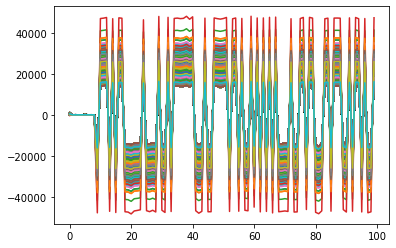

In [6]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

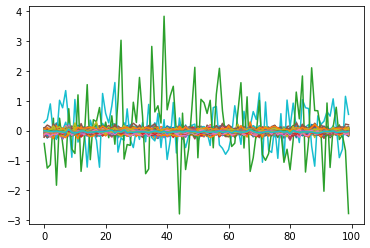

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

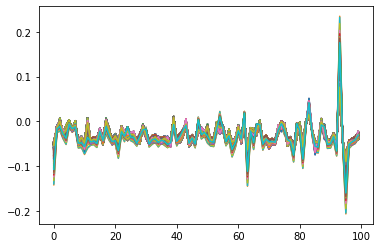

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

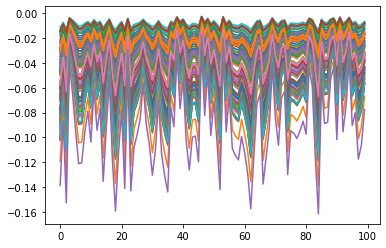

In [8]:
ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i])

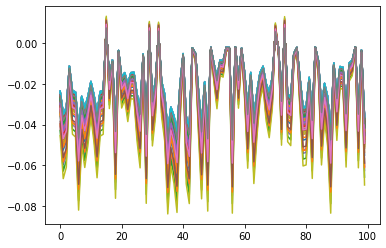

In [13]:
ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i]/-1e10)

In [7]:
ps_fake

tensor([[2.9931e+08, 4.3878e+08, 4.0206e+08,  ..., 4.0381e+08, 4.1310e+07,
         4.5880e+08],
        [4.2777e+08, 6.2704e+08, 5.7457e+08,  ..., 5.7697e+08, 5.8824e+07,
         6.5672e+08],
        [3.0092e+08, 4.4114e+08, 4.0422e+08,  ..., 4.0597e+08, 4.1520e+07,
         4.6132e+08],
        ...,
        [3.0171e+08, 4.4229e+08, 4.0528e+08,  ..., 4.0703e+08, 4.1624e+07,
         4.6256e+08],
        [2.8306e+08, 4.1499e+08, 3.8025e+08,  ..., 3.8196e+08, 3.9181e+07,
         4.3336e+08],
        [5.1677e+08, 7.5750e+08, 6.9412e+08,  ..., 6.9701e+08, 7.1061e+07,
         7.9336e+08]])

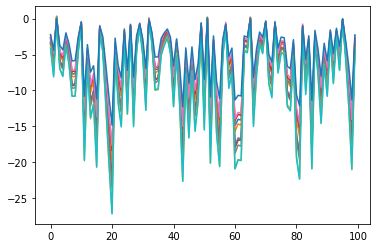

In [20]:
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i].cpu())
    if i == 10:
        break

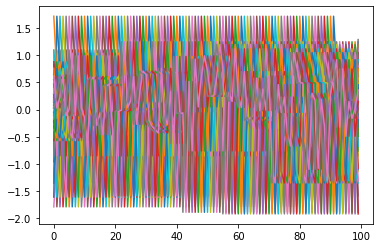

In [47]:
for data in dataloader:
    ps_real = data[0].permute(0,2,1).squeeze(-1)
    for i in range(len(ps_real)):
        plt.plot(list(range(100)),ps_real[i].cpu())

    break

In [43]:
ts_real = trade_strategy.get_strategy_PnL(ps_real).cpu()#,torch.ones_like(ps_real))
ts_fake = trade_strategy.get_strategy_PnL(ps_fake).cpu()#,torch.ones_like(ps_fake))

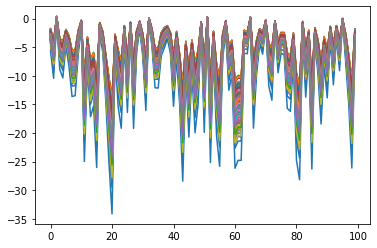

In [46]:
for i in range(len(ps_real)):
#     plt.plot(list(range(100)),ts_real[i])
    plt.plot(list(range(100)),ts_fake[i])

In [ ]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

## Results and visualizing stylized facts

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

In [56]:
t = torch.tensor([1.,5.,3.],requires_grad = True)
b = torch.tensor([1.,2.,3.]).reshape(-1,1)
result = torch.matmul(torch.sort(t)[0],b)
result.backward()
t.grad

tensor([1., 3., 2.])

In [57]:
result.backward()
t.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
result = torch.matmul(torch.sort(t)[0],b)
result.backward()
t.grad

In [25]:
t = torch.tensor([[1.,5.,3.],[1.,5.,3.],[1.,5.,3.]],requires_grad = True)
s =torch.cumsum(t,dim=1)
s

tensor([[1., 6., 9.],
        [1., 6., 9.],
        [1., 6., 9.]], grad_fn=<CumsumBackward0>)

In [12]:
(t>t).long()

tensor([0, 0, 0], device='cuda:0')

In [53]:
t.detach().cpu().cuda().cuda()

tensor([1., 5., 3.], device='cuda:0')

In [11]:
tanh = nn.Tanh()

In [13]:
tanh(t)

tensor([0.7616, 0.9999, 0.9951], device='cuda:0', grad_fn=<TanhBackward0>)

In [12]:
torch.arange(1,10)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
s[:,1:] - s[:,-1].reshape(-1,1)

tensor([[-3.,  0.],
        [-3.,  0.],
        [-3.,  0.]], device='cuda:0', grad_fn=<SubBackward0>)

In [20]:
z = torch.zeros(3).unsqueeze(1)
torch.cat((z,s),dim=1)

tensor([[0., 1., 6., 9.],
        [0., 1., 6., 9.],
        [0., 1., 6., 9.]], grad_fn=<CatBackward0>)

In [33]:
def running_mean(x, N):
    zeros = torch.zeros(x.size()[0]).unsqueeze(1)
    ma = torch.cat((zeros,x),dim=1)
    ma = torch.cumsum(ma,dim=1) 
#     print(ma)
#     print(ma[:,N:] - ma[:,:-N])
    ma = (ma[:,N:] - ma[:,:-N]) / float(N)
    ma = torch.cat((x[:,:N-1],ma),dim=1)
    return ma
running_mean(s,2)

tensor([[ 0.,  1.,  7., 16.],
        [ 0.,  1.,  7., 16.],
        [ 0.,  1.,  7., 16.]], grad_fn=<CumsumBackward0>)
tensor([[ 7., 15.],
        [ 7., 15.],
        [ 7., 15.]], grad_fn=<SubBackward0>)


tensor([[1.0000, 3.5000, 7.5000],
        [1.0000, 3.5000, 7.5000],
        [1.0000, 3.5000, 7.5000]], grad_fn=<CatBackward0>)

In [8]:
torch.linspace(0,0, steps=(1,2))

TypeError: linspace(): argument 'steps' must be int, not tuple